In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import cv2
from fcmeans import FCM

# explanable AI
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

Using TensorFlow backend.


In [2]:
##### get a list of all the punks ######
path = r"/Users/wendy/Documents/GitHub/UMAP/Crypto_punks"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
punks = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
    # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
            # adds only the image files to the punks list
             punks.append(file.name)

In [4]:
path = r"/Users/wendy/Documents/GitHub/VizTech"
# change the working directory to the path where the images are located
os.chdir(path)
punk_price_in = pd.read_csv('./data/punk_price.csv')
punk_traits = pd.read_csv('./data/punk_traits.csv')

In [5]:
####### punk index ######
punk_index = []
for i in range(len(punks)):
    punk_n = punks[i].replace(".png", '')
    punk_n1 = "CryptoPunk #" + punk_n
    punk_index.append(punk_n1)

punk_index_df= pd.DataFrame(punk_index)
punk_index_df.columns = ['name']

#punk_index_df.to_csv('/Users/wendy/Documents/DAI/punk_index_df.csv')
punk_name = []
for i in range(len(punk_traits['name'])):
    punk_n = punk_traits['name'][i].replace("CryptoPunk #", '')
    if len(punk_n)== 1:
        punk_n1 = "CryptoPunk #000" + punk_n
    elif len(punk_n)== 2:
        punk_n1 = "CryptoPunk #00" + punk_n
    elif len(punk_n)== 3:
        punk_n1 = "CryptoPunk #0" + punk_n
    else:
        punk_n1 = "CryptoPunk #" + punk_n
    punk_name.append(punk_n1)

punk_traits['name'] = punk_name

In [6]:
# create punk_df of traits and prices
punk_df_in = punk_index_df.merge(punk_traits,how='left',on=['name'])
punk_price = punk_price_in[['name','total_price','total_usd_price']]
punk_df = punk_df_in.merge(punk_price,how='left',on=['name'])

In [7]:
# seperate trait_type and accesories
import ast
trait_type = []
trait_value = []
for obj in punk_df['traits']:
    d= ast.literal_eval(obj)
    t_v = []
    t_t = []
    for trait in d:
        t_v.append(trait['value'])
        t_t.append(trait['trait_type'])
    trait_type.append(t_t)
    trait_value.append(t_v)
punk_df['trait_value']=trait_value
punk_df['trait_type']=trait_type


cd = punk_df.trait_value.reset_index(drop = True)
ef = punk_df.trait_type.reset_index(drop = True)
call_1=[]
call_2=[]
for i in range(len(punk_df)):
    tr_v = np.array(cd[i])
    tr_t = ef[i]
    if tr_t != 0:
        index1 = [index for index, x in enumerate(tr_t) if x == 'type']
        index2 = [index for index, x in enumerate(tr_t) if x == 'accessory']
        if bool(index1)!= False:
            call_1.append(tr_v[index1][0])
        else:
            call_1.append(['no type'])
        if bool(index2)!= False:
            call_2.append(tr_v[index2].tolist())
        else:
            call_2.append(['no accessory'])
    else:
        call_1.append('no type')
        call_2.append('no accessory')
punk_df['punk_type']=call_1
punk_df['punk_accessory']=call_2

In [8]:
# add punk_filename
punkname = punk_df['name']
punk_filename = []
for i in range(len(punkname)):
    punk_n2 = punkname[i].replace("CryptoPunk #", '')
    punk_n3 = punk_n2 + ".png"
    punk_filename.append(punk_n3)
punk_df['punk_filename'] = punk_filename

In [9]:
# one_hot transform of punk accessories
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
oht_matrix = one_hot.fit_transform(punk_df['punk_accessory'])
print(one_hot.classes_)

['0 attributes' '1 attributes' '2 attributes' '3 attributes' '3D Glasses'
 '4 attributes' '5 attributes' '6 attributes' '7 attributes' 'Bandana'
 'Beanie' 'Big Beard' 'Big Shades' 'Black Lipstick' 'Blonde Bob'
 'Blonde Short' 'Blue Eye Shadow' 'Buck Teeth' 'Cap' 'Cap Forward'
 'Chinstrap' 'Choker' 'Cigarette' 'Classic Shades' 'Clown Eyes Blue'
 'Clown Eyes Green' 'Clown Hair Green' 'Clown Nose' 'Cowboy Hat'
 'Crazy Hair' 'Dark Hair' 'Do-rag' 'Earring' 'Eye Mask' 'Eye Patch'
 'Fedora' 'Front Beard' 'Front Beard Dark' 'Frown' 'Frumpy Hair' 'Goat'
 'Gold Chain' 'Green Eye Shadow' 'Half Shaved' 'Handlebars' 'Headband'
 'Hoodie' 'Horned Rim Glasses' 'Hot Lipstick' 'Knitted Cap'
 'Luxurious Beard' 'Medical Mask' 'Messy Hair' 'Mohawk' 'Mohawk Dark'
 'Mohawk Thin' 'Mole' 'Mustache' 'Muttonchops' 'Nerd Glasses'
 'Normal Beard' 'Normal Beard Black' 'Orange Side' 'Peak Spike' 'Pigtails'
 'Pilot Helmet' 'Pink With Hat' 'Pipe' 'Police Cap' 'Purple Eye Shadow'
 'Purple Hair' 'Purple Lipstick' 'Red M

In [10]:
len(one_hot.classes_)

95

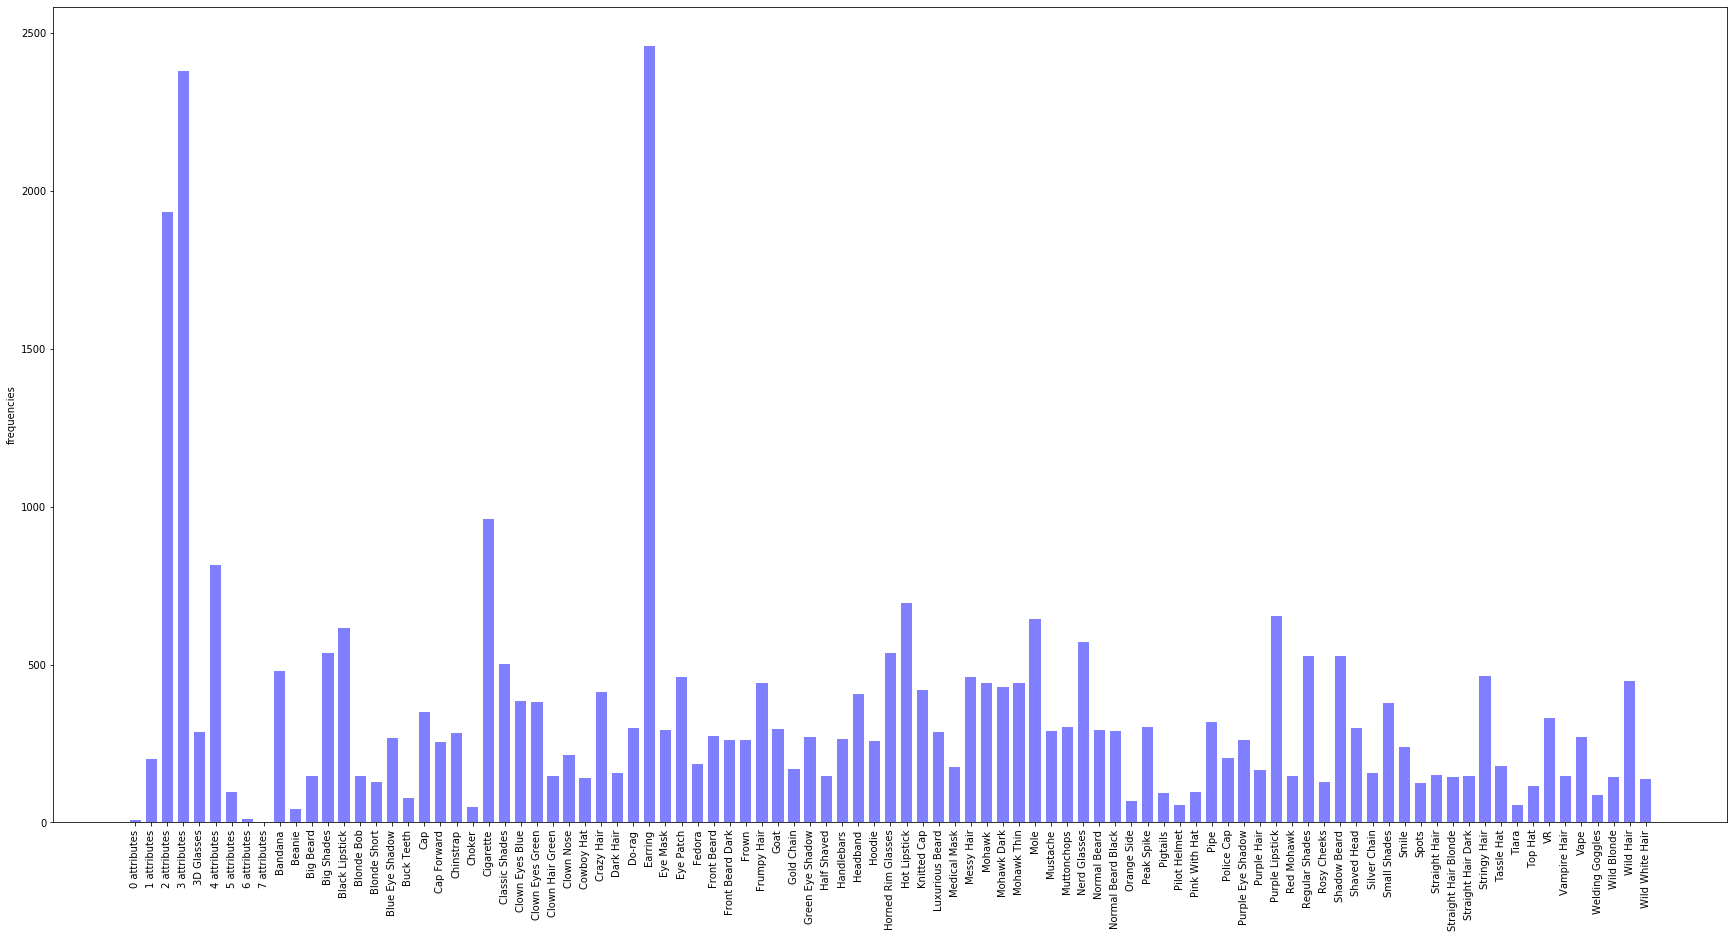

In [11]:
plt.figure(figsize=(30, 15))
# make a little extra space between the subplots
plt.bar(one_hot.classes_, oht_matrix.sum(axis=0), width=0.7, align ='center',color='blue', alpha=0.5 )
plt.ylabel('frequencies')
plt.xticks(rotation=90)
plt.savefig('./trait_frequencies.png',transparent=True)

In [12]:
# Hierarchical clustering model settings with hamming distance on punk_accessories
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(oht_matrix, 'complete','hamming')
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(oht_matrix))

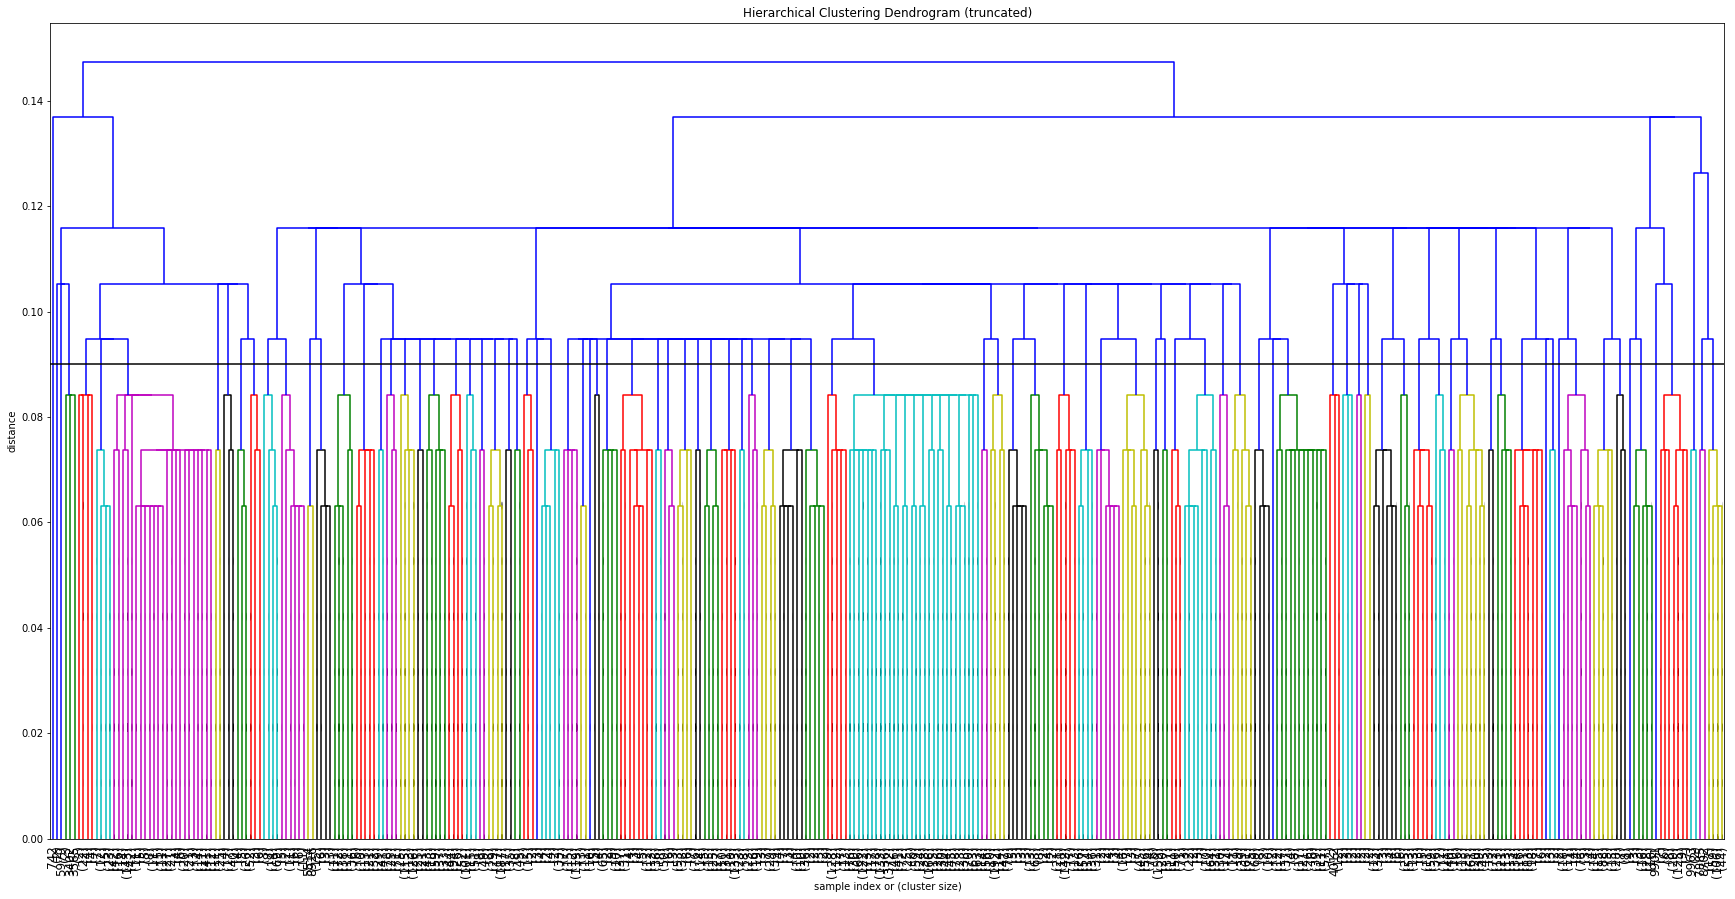

In [13]:
#plot truncated dendrogram
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

    
plt.figure(figsize=(30, 15))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=380,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  #useful in small plots so annotations don't overlap
    max_d= 0.09
)
plt.savefig('./Hierarchical Clustering Dendrogram(truncated).png',transparent=True)

In [14]:
# hierarchical clustering
from scipy.cluster.hierarchy import fcluster
max_d = 0.09
labels3 = fcluster(Z, max_d, criterion='distance')
punk_df['labels_hier1'] = labels3

In [15]:
punk_df.groupby(['labels_hier1']).count()

name  Unnamed: 0  traits  trait_type  trait_value  total_price  \
labels_hier1                                                                   
1                2           2       2           2            2            2   
2                4           4       4           4            4            4   
3                1           1       1           1            1            1   
4               32          32      32          32           32           32   
5               47          47      47          47           47           47   
...            ...         ...     ...         ...          ...          ...   
89             182         182     182         182          182          182   
90               1           1       1           1            1            1   
91               3           3       3           3            3            3   
92               2           2       2           2            2            2   
93             226         226     226         226          226          226   

              total_usd_price  punk_type  punk_accessory  punk_filename  
labels_hier1                                                             
1                           2          2               2              2  
2                           4          4               4              4  
3                           1          1               1              1  
4                          32         32              32             32  
5                          47         47              47             47  
...                       ...        ...             ...            ...  
89                        182        182             182            182  
90                          1          1               1              1  
91                          3          3               3              3  
92                          2          2               2              2  
93                        226        226             226            226  

[93 rows x 10 columns]

In [16]:
import copy
sele_index = punk_df.groupby(['labels_hier1']).head(300).index
punkdf1 = copy.copy(punk_df)
punkdf1.drop(sele_index, axis=0, inplace=True)

#create validation set and training set for classification
val_set = punkdf1
training_set = punk_df.iloc[sele_index]
test_set = training_set.groupby(['labels_hier1']).tail(20)
test_index = test_set.index
training_set.drop(test_index, axis=0, inplace=True)

#create validation set and training set for regression
val_set1 = val_set[val_set['total_price']!=0]
training_set1 = training_set[training_set['total_price']!=0]
test_set1 = test_set[test_set['total_price']!=0]

val = list(val_set.punk_filename)
train = list(training_set.punk_filename)
test = list(test_set.punk_filename)

val1 = list(val_set1.punk_filename)
train1 = list(training_set1.punk_filename)
test1 = list(test_set1.punk_filename)

/Users/wendy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
##### load punk images for regression ######
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
p = r"/Users/wendy/Documents/GitHub/UMAP/Crypto_punks/"
def reshape_images(file):
    img = load_img(file, target_size=(24,24,3)) # load 24x24 data
    #img = load_img(file, target_size=(240,240,3)) # load 240x240 data
    img = np.array(img)
    return (img)

train_images = {}
for punk in train1:
    # try to extract the features and update the dictionary
    feat = reshape_images(p+punk)
    train_images[punk] = feat

val_images={}
for punk in val1:
    # try to extract the features and update the dictionary
    feat = reshape_images(p+punk)
    val_images[punk] = feat

test_images = {}
for punk in test1:
    # try to extract the features and update the dictionary
    feat = reshape_images(p+punk)
    test_images[punk] = feat



In [18]:
######### train test split for regression ########
X_train = np.array(list(train_images.values()))/ 255
y_train = np.log(np.array(training_set1['total_price']))
X_val = np.array(list(val_images.values()))/ 255
y_val = np.log(np.array(val_set1['total_price']))
X_test = np.array(list(test_images.values()))/ 255
y_test = np.log(np.array(test_set1['total_price']))

In [19]:
#########  Regression CNN model setting  #########
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model,Sequential

model_re1 = Sequential(
    [
    Conv2D (filters =64, kernel_size =3, padding='same', activation="relu",input_shape=(24, 24, 3), name="input_layer"),
    Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu',name="layer1"),
    MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer2"),

    Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu',name="layer3"),
    Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu',name="layer4"),
    MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer5"),

    Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu',name="layer6"),
    Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu',name="layer7"),
    Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu',name="layer8"),
    MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer9"),

    Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer10"),
    Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer11"),
    Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer12"),
    MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer13"),
    
    Flatten(),
    Dense(units = 4096, activation ='relu', name="layer14"),
    Dropout(0.2,seed = 12321),
    Dense(1 , activation = 'linear',name="output_layer")
]
)

loss_used = 'mean_squared_error'
metrics = ['MeanAbsoluteError']
batch_size = 60
epochs = 10

model_re1.compile(optimizer = RMSprop(lr = 0.0001), loss = loss_used, metrics = metrics)
model_re1.summary()

'''Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer14"),
    Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer15"),
    Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer16"),
    MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer17"),'''

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 24, 24, 64)        1792      
_________________________________________________________________
layer1 (Conv2D)              (None, 24, 24, 64)        36928     
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 12, 12, 64)        0         
_________________________________________________________________
layer3 (Conv2D)              (None, 12, 12, 128)       73856     
_________________________________________________________________
layer4 (Conv2D)              (None, 12, 12, 128)       147584    
_________________________________________________________________
layer5 (MaxPooling2D)        (None, 6, 6, 128)         0         
_________________________________________________________________
layer6 (Conv2D)              (None, 6, 6, 256)         2

'Conv2D (filters =512, kernel_size =3, padding =\'same\', activation=\'relu\',name="layer14"),\n    Conv2D (filters =512, kernel_size =3, padding =\'same\', activation=\'relu\',name="layer15"),\n    Conv2D (filters =512, kernel_size =3, padding =\'same\', activation=\'relu\',name="layer16"),\n    MaxPool2D(pool_size =2, strides =2, padding =\'same\',name="layer17"),'

In [20]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_filepath = '/Users/wendy/Documents/GitHub/UMAP/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=3),
             model_checkpoint_callback,
]

In [21]:
# train the model on 24x24 image data
import tensorflow as tf
tf.random.set_seed(987)
history_re1 = model_re1.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val),callbacks=callbacks)

Train on 3336 samples, validate on 847 samples
Epoch 1/30
3328/3336 [============================>.] - ETA: 0s - loss: 4.5268 - MeanAbsoluteError: 1.6128WARNING:tensorflow:From /Users/wendy/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/wendy/Documents/GitHub/UMAP/checkpoint/assets
3336/3336 [==============================] - 83s 25ms/sample - loss: 4.5291 - MeanAbsoluteError: 1.6125 - val_loss: 5.5309 - val_MeanAbsoluteError: 2.1090
Epoch 2/30
3336/3336 [==============================] - 100s 30ms/sample - loss: 3.0046 - MeanAbsoluteError: 1.3817 - val_loss: 4.7738 - val_MeanAbsoluteError: 1.9474
Epoch 3/30
3336/3336 [==============================] - 84s 25m

In [113]:
# train the model on 240x240 image data
import tensorflow as tf
tf.random.set_seed(987)
history_re2 = model_re1.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val),callbacks=callbacks)

Train on 3336 samples, validate on 847 samples
Epoch 1/30
3328/3336 [============================>.] - ETA: 8s - loss: 226.5561 - MeanAbsoluteError: 2.7690 WARNING:tensorflow:From /Users/wendy/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/wendy/Documents/GitHub/UMAP/checkpoint/assets
3336/3336 [==============================] - 3719s 1s/sample - loss: 226.0245 - MeanAbsoluteError: 2.7659 - val_loss: 3.2929 - val_MeanAbsoluteError: 1.5600
Epoch 2/30
3336/3336 [==============================] - 180997s 54s/sample - loss: 3.0591 - MeanAbsoluteError: 1.3847 - val_loss: 5.2137 - val_MeanAbsoluteError: 2.0423
Epoch 3/30
3336/3336 [==============================] - 

In [114]:
metrics_df1 = pd.DataFrame(history_re2.history)
metrics_df1.to_csv('./regression_metrics240')

In [127]:
from tensorflow.keras.models import load_model
model_re1.save('./model_re1_240.h5')
#model_re1 = load_model('/Users/wendy/Documents/GitHub/UMAP/model_re1.h5')
#test_loss, test_mae = model_re1.evaluate(X_test,  y_test, verbose=2)

In [122]:
test_loss, test_mae = model_re1.evaluate(X_test,  y_test, verbose=2)

781/1 - 311s - loss: 2.7642 - MeanAbsoluteError: 1.3545


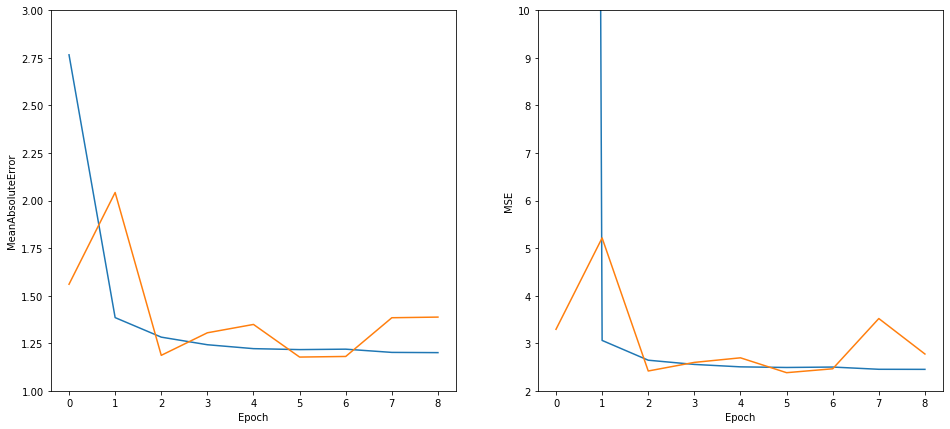

In [119]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(metrics_df1['MeanAbsoluteError'], label='MeanAbsoluteError')
plt.plot(metrics_df1['val_MeanAbsoluteError'], label = 'val_MeanAbsoluteError')
plt.xlabel('Epoch')
plt.ylabel('MeanAbsoluteError')
plt.ylim([1, 3])

plt.subplot(1, 2, 2)
plt.plot(metrics_df1['loss'], label='loss')
plt.plot(metrics_df1['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([2, 10])

plt.savefig('/Users/wendy/Documents/GitHub/UMAP/Regressor_metrics240.png',transparent=True)

In [20]:
from numpy import expand_dims
img = load_img(r'./Crypto_punks/5096.png', target_size=(240, 240, 3))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
model_re1.predict(img)

NameError: name 'expand_dims' is not defined

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_input (InputLaye [(None, 24, 24, 3)]       0         
_________________________________________________________________
input_layer (Conv2D)         (None, 24, 24, 64)        1792      
_________________________________________________________________
layer1 (Conv2D)              (None, 24, 24, 64)        36928     
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 12, 12, 64)        0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


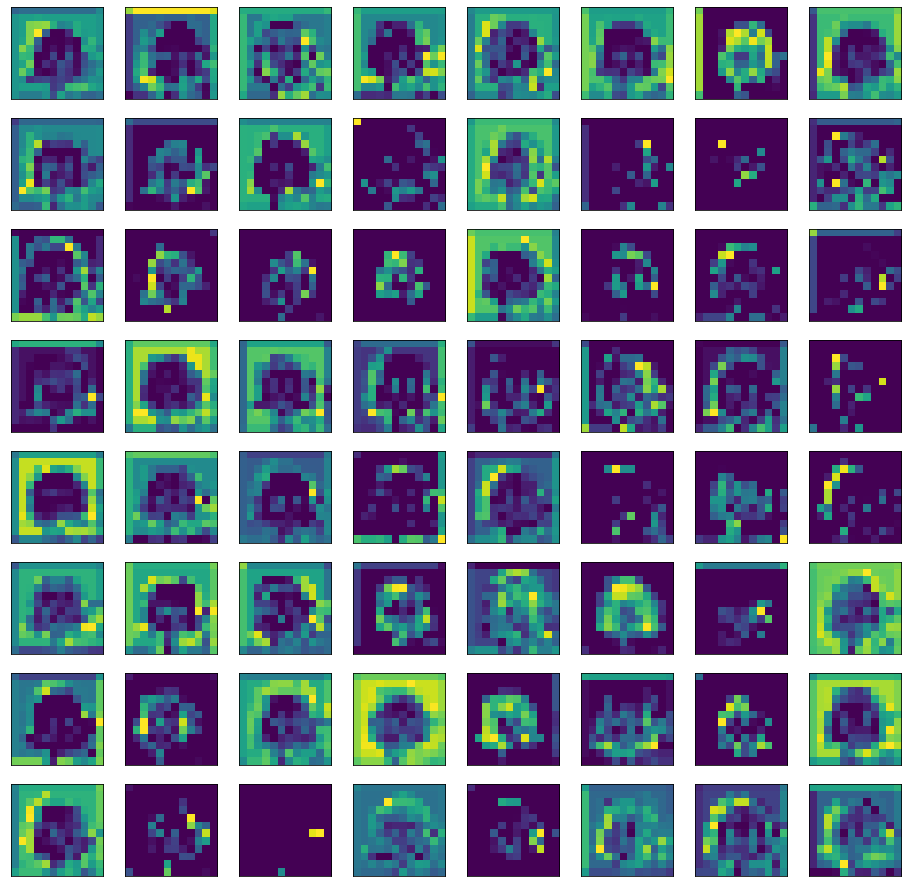

In [166]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot 
from numpy import expand_dims


f = plt.figure(figsize=(16,16))
model = model_re1
model = Model(inputs=model_re1.inputs, outputs=model_re1.layers[2].output)
model.summary()

# load the image with the required shape
img = load_img(r'/Users/wendy/Documents/GitHub/UMAP/Crypto_punks/5096.png', target_size=(24, 24))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
#plt.savefig('./Regressor_layer1.png',transparent=True)


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_input (InputLaye [(None, 24, 24, 3)]       0         
_________________________________________________________________
input_layer (Conv2D)         (None, 24, 24, 64)        1792      
_________________________________________________________________
layer1 (Conv2D)              (None, 24, 24, 64)        36928     
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 12, 12, 64)        0         
_________________________________________________________________
layer3 (Conv2D)              (None, 12, 12, 128)       73856     
_________________________________________________________________
layer4 (Conv2D)              (None, 12, 12, 128)       147584    
_________________________________________________________________
layer5 (MaxPooling2D)        (None, 6, 6, 128)         0  

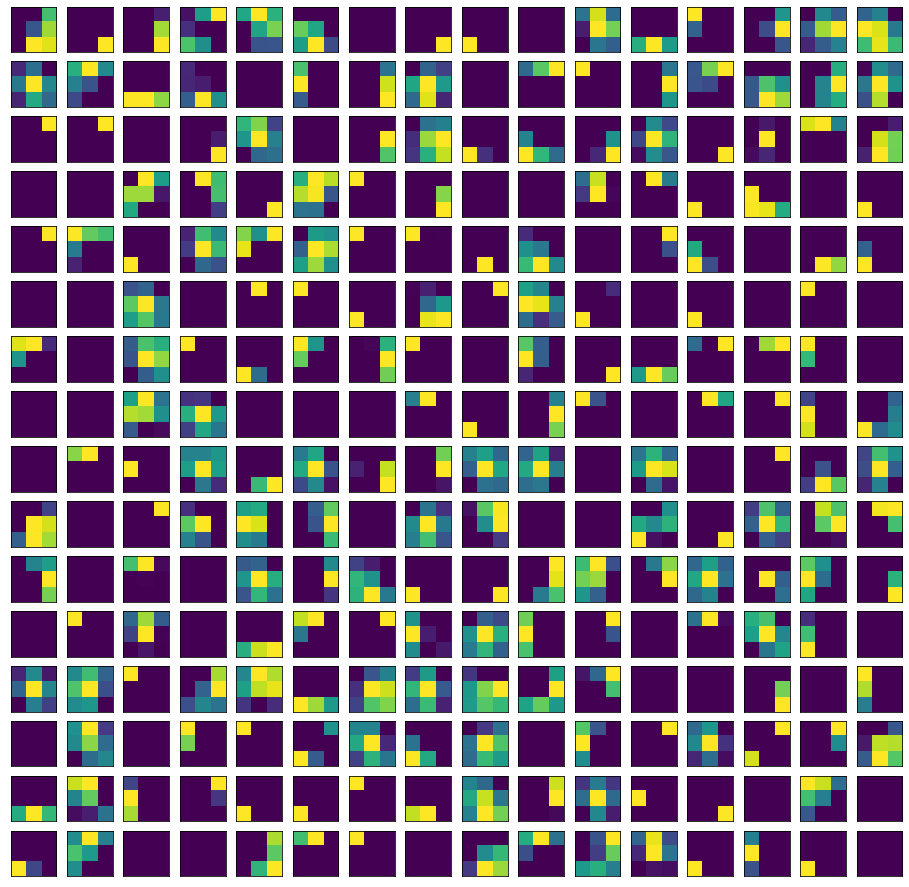

In [274]:
f = plt.figure(figsize=(16,16))
model = Model(inputs=model_re1.inputs, outputs=model_re1.layers[11].output)
model.summary()

# load the image with the required shape
img = load_img(r'/Users/wendy/Documents/GitHub/UMAP/Crypto_punks/5096.png', target_size=(24, 24))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 16
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
#plt.savefig('./Regressor_layer7.png',transparent=True)

In [275]:
punk_all_df = punk_df[punk_df['total_price']!=0]
punk_all = punk_all_df['punk_filename']

In [276]:
feature_model = Model(inputs = model_re1.inputs, outputs = model_re1.layers[-2].output)
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(24,24,3))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)/255
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,24,24,3)
    # get the feature vector
    features = model.predict(reshaped_img, use_multiprocessing=True)
    return features

data = {}
p = r"/Users/wendy/Documents/GitHub/UMAP/Crypto_punks/"

# loop through each image in the dataset
for punk in punk_all:
    # try to extract the features and update the dictionary
    feat = extract_features(p+punk,feature_model)
    data[punk] = feat
    

In [350]:
y_pre = []
for i in range(np.shape(X_test)[0]):
    img = X_test[i,:,:,:]
    reshaped_img = img.reshape(1,24,24,3)
    pre = model_re1.predict(reshaped_img, use_multiprocessing=True)
    y_pre.append(pre)

Text(0, 0.5, 'values')

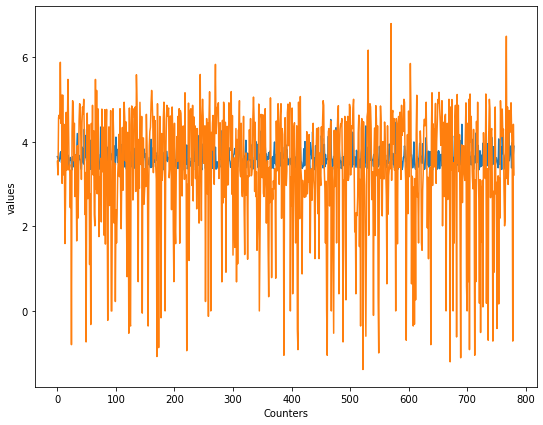

In [357]:
y_pre1 = np.array(y_pre).reshape(781)
xx = range(781)
plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1)
plt.plot(y_pre1)
plt.plot(y_test)
plt.xlabel('Counters')
plt.ylabel('values')
#plt.ylim([1, 3])

In [133]:
##### load punk images for classification ######
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
p = r"/Users/wendy/Documents/GitHub/UMAP/Crypto_punks/"
def reshape_images(file):
    img = load_img(file, target_size=(24,24,3))
    img = np.array(img)
    return (img)

train_images_cl = {}
for punk in train:
    # try to extract the features and update the dictionary
    feat = reshape_images(p+punk)
    train_images_cl[punk] = feat

val_images_cl = {}
for punk in val:
    # try to extract the features and update the dictionary
    feat = reshape_images(p+punk)
    val_images_cl[punk] = feat

test_images_cl = {}
for punk in test:
    # try to extract the features and update the dictionary
    feat = reshape_images(p+punk)
    test_images_cl[punk] = feat


In [101]:
######### train test split for classification ########
X_train_cl = np.array(list(train_images_cl.values()))/ 255
y_train_cl = np.array(training_set['total_price']!=0,dtype=int)
X_val_cl = np.array(list(val_images_cl.values()))/ 255
y_val_cl = np.array(val_set['total_price']!=0,dtype=int)
X_test_cl = np.array(list(test_images_cl.values()))/ 255
y_test_cl = np.array(test_set['total_price']!=0,dtype=int)

In [97]:
#import Regressor
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
#pre_trained_model = VGG16(input_shape = (32, 32, 3),include_top = False, weights = 'imagenet')
pre_trained_model = load_model(checkpoint_filepath)
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

#Add dense layer
last_layer = pre_trained_model.get_layer('layer17') 
#last_layer = pre_trained_model.get_layer('block5_conv3')
last_layer.output_shape
last_output = last_layer.output
from sys import last_traceback

loss_used_cl = 'binary_crossentropy'
metrics_cl = ['accuracy']
batch_size = 12
epochs = 10
'''x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer10")(last_output)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer11")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer12")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer13")(x)

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer14")(last_output)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer15")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu',name="layer16")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same',name="layer17")(x)'''

x = Flatten()(last_output)
x = Dense(4096,activation='selu',name="layer18")(x)
x = Dense(4096,activation='selu',name="layer19")(x)
#x = Dense(512,activation='relu',name="layer20")(x)
#x = Dense(512,activation='relu',name="layer21")(x)
#x = Dropout(0.2)(x)
x = Dense(1, activation = 'sigmoid',name="output_layer")(x)

from tensorflow.keras.optimizers import SGD
model_cl1 = Model (inputs = pre_trained_model.input, outputs =x)
model_cl1.compile(optimizer = SGD(learning_rate=0.0001, momentum=0.9), loss = loss_used_cl, metrics = metrics_cl)
#model_cl1.compile(optimizer = RMSprop(lr = 0.0001), loss = loss_used_cl, metrics = metrics_cl)

model_cl1.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_input (InputLaye [(None, 24, 24, 3)]       0         
_________________________________________________________________
input_layer (Conv2D)         (None, 24, 24, 64)        1792      
_________________________________________________________________
layer1 (Conv2D)              (None, 24, 24, 64)        36928     
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 12, 12, 64)        0         
_________________________________________________________________
layer3 (Conv2D)              (None, 12, 12, 128)       73856     
_________________________________________________________________
layer4 (Conv2D)              (None, 12, 12, 128)       147584    
_________________________________________________________________
layer5 (MaxPooling2D)        (None, 6, 6, 128)         0  

In [133]:
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense 
from tensorflow.keras.optimizers import Adam,SGD

# input

input = Input(shape =(24,24,3))
# 1st Conv Block

x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block

x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers

x = Flatten()(x)
x = Dense(units = 4096, activation ='selu')(x)
x = Dense(units = 4096, activation ='selu')(x)
x = Dropout(0.2)(x)
output = Dense(units = 1, activation ='sigmoid')(x)
#output = Dense(units = 2, activation ='softmax')(x)
# creating the model

model_cl1 = Model (inputs=input, outputs =output)
model_cl1.summary()

loss_used_cl = 'binary_crossentropy'
#loss_used_cl = 'sparse_categorical_crossentropy'
metrics_cl = ['accuracy']
batch_size = 12
epochs = 50
#model_cl.compile(optimizer = RMSprop(lr = 0.0001), loss = loss_used_cl, metrics = metrics_cl)
model_cl1.compile(optimizer =  SGD(learning_rate=0.0001, momentum=0.9), loss = loss_used_cl, metrics = metrics_cl)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 24, 3)]       0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 24, 24, 64)        1792      
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 6, 6, 128)         0  

In [134]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_filepath_cl = '/Users/wendy/Documents/GitHub/UMAP/checkpoint_cl'
model_checkpoint_callback_cl = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_cl,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

callbacks_cl = [
             EarlyStopping(patience=3),
             model_checkpoint_callback_cl,
]

In [135]:
history_cl3 = model_cl1.fit(X_train_cl, y_train_cl, epochs=10, 
                    validation_data=(X_val_cl, y_val_cl))#,callbacks=callbacks_cl)

Train on 6596 samples, validate on 1868 samples
Epoch 1/10
6596/6596 [==============================] - 177s 27ms/sample - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6938 - val_accuracy: 0.4534
Epoch 2/10
6596/6596 [==============================] - 173s 26ms/sample - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6942 - val_accuracy: 0.4534
Epoch 3/10
6596/6596 [==============================] - 174s 26ms/sample - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6945 - val_accuracy: 0.4534
Epoch 4/10
6596/6596 [==============================] - 173s 26ms/sample - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6942 - val_accuracy: 0.4534
Epoch 5/10
6596/6596 [==============================] - 172s 26ms/sample - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6940 - val_accuracy: 0.4534
Epoch 6/10
6596/6596 [==============================] - 173s 26ms/sample - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6943 - val_accuracy: 0.4534
Epoch 7/10
6596/6596 [==============================] - 17

In [136]:
metrics_df3 = pd.DataFrame(history_cl3.history)
#metrics_df1 = metrics_df.append(metrics_df3)
metrics_df3.to_csv('./classification_metrics3')

In [95]:
model_cl5 = load_model('./model_cl4.h5')

In [138]:
test_loss, test_mae = model_cl5.evaluate(X_test_cl,  y_test_cl, verbose=2)

1536/1 - 12s - loss: 0.7523 - accuracy: 0.5254


In [115]:
metrics_df = metrics_df1.append(metrics_df2)
metrics_RMS = metrics_df.append(metrics_df3)

In [103]:
#######
metrics_df4 = pd.DataFrame(history_cl4.history)
metrics_df5 = pd.DataFrame(history_cl5.history)
metrics_SGD = metrics_df4.append(metrics_df5)
metrics_dfcl = metrics_RMS.append(metrics_SGD)
metrics_dfcl1 = metrics_dfcl.reset_index(drop=True)

NameError: name 'history_cl4' is not defined

In [21]:
punk_df[punk_df['total_price']!=0]

name  Unnamed: 0  \
1     CryptoPunk #8820       14465   
3     CryptoPunk #1804       16417   
4     CryptoPunk #4968       11683   
7     CryptoPunk #6819       11929   
8     CryptoPunk #8834       20637   
...                ...         ...   
9989  CryptoPunk #6828       19409   
9990  CryptoPunk #3978       17622   
9994  CryptoPunk #4971       11487   
9995  CryptoPunk #4965       18249   
9996  CryptoPunk #8187       12698   

                                                 traits  \
1     [{'trait_type': 'accessory', 'value': 'Eye Mas...   
3     [{'trait_type': 'accessory', 'value': 'Mole', ...   
4     [{'trait_type': 'accessory', 'value': '3 attri...   
7     [{'trait_type': 'accessory', 'value': '3 attri...   
8     [{'trait_type': 'accessory', 'value': 'Earring...   
...                                                 ...   
9989  [{'trait_type': 'type', 'value': 'Male', 'disp...   
9990  [{'trait_type': 'accessory', 'value': 'Wild Ha...   
9994  [{'trait_type': 'accessory', 'value': '5 attri...   
9995  [{'trait_type': 'accessory', 'value': '3 attri...   
9996  [{'trait_type': 'accessory', 'value': 'VR', 'd...   

                                             trait_type  \
1                          [accessory, type, accessory]   
3               [accessory, accessory, type, accessory]   
4     [accessory, accessory, accessory, type, access...   
7     [accessory, accessory, accessory, type, access...   
8               [accessory, accessory, type, accessory]   
...                                                 ...   
9989            [type, accessory, accessory, accessory]   
9990            [accessory, type, accessory, accessory]   
9994  [accessory, accessory, accessory, type, access...   
9995  [accessory, accessory, type, accessory, access...   
9996  [accessory, accessory, type, accessory, access...   

                                            trait_value  total_price  \
1                         [Eye Mask, Male, Mohawk Thin]        98.00   
3              [Mole, Messy Hair, Female, 2 attributes]        23.00   
4     [3 attributes, Earring, Shadow Beard, Male, Mo...        22.39   
7     [3 attributes, Buck Teeth, Cap, Male, Front Be...        55.00   
8             [Earring, Shadow Beard, Male, Police Cap]        21.49   
...                                                 ...          ...   
9989          [Male, Peak Spike, Handlebars, Eye Patch]        75.99   
9990                     [Wild Hair, Male, Mole, Smile]        40.00   
9994  [5 attributes, Earring, Eye Patch, Male, Mohaw...         0.49   
9995  [3 attributes, Normal Beard, Male, Nerd Glasse...        82.95   
9996  [VR, Earring, Female, Hot Lipstick, Tassle Hat...        25.00   

      total_usd_price punk_type  \
1         256465.0200      Male   
3          33580.0000    Female   
4          40458.7300      Male   
7         100265.0000      Male   
8          38660.5100      Male   
...               ...       ...   
9989      198865.0701      Male   
9990       89520.0000      Male   
9994         130.8300      Male   
9995      217079.3205      Male   
9996       34225.0000    Female   

                                         punk_accessory punk_filename  \
1                               [Eye Mask, Mohawk Thin]      8820.png   
3                      [Mole, Messy Hair, 2 attributes]      1804.png   
4         [3 attributes, Earring, Shadow Beard, Mohawk]      4968.png   
7     [3 attributes, Buck Teeth, Cap, Front Beard Dark]      6819.png   
8                   [Earring, Shadow Beard, Police Cap]      8834.png   
...                                                 ...           ...   
9989                [Peak Spike, Handlebars, Eye Patch]      6828.png   
9990                           [Wild Hair, Mole, Smile]      3978.png   
9994  [5 attributes, Earring, Eye Patch, Mohawk, Fro...      4971.png   
9995  [3 attributes, Normal Beard, Nerd Glasses, Kni...      4965.png   
9996  [VR, Earring, Hot Lipstick, Tassle Hat, Cigare..

In [22]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
punk_all = punk_df['punk_filename']
img_path_all = []
for punk in punk_all:
    path = p+punk
    img_path_all.append(path)

punk_df_sale = punk_df[punk_df['total_price']!=0]
punk_sale = punk_df_sale ['punk_filename']
img_path_sale = []
for punk in punk_sale:
    path = p+punk
    img_path_sale.append(path)

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def getImage(path):
    return OffsetImage(plt.imread(path))

def plot_embed(embed,method,p_color, traits, clusters):
    fig = plt.figure(figsize=(40,40))
    ax1 = fig.add_subplot(221)
    im1 = ax1.scatter(embed[:, 0], embed[:, 1]) 
    im1.axes.get_xaxis().set_ticks([])
    im1.axes.get_yaxis().set_ticks([])
    for x0, y0, path in zip(embed[:, 0], embed[:, 1],img_path_sale):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax1.add_artist(ab)
    
    color = pd.DataFrame(np.log(p_color)).replace(-np.inf,0).iloc[:,0]
    orig_map=plt.cm.get_cmap('terrain')
    reversed_map = orig_map.reversed()
    ax2 = fig.add_subplot(222)
    im2 = ax2.scatter(embed[:, 0], embed[:, 1], c= np.array(color), cmap=reversed_map)
    im2.axes.get_xaxis().set_ticks([])
    im2.axes.get_yaxis().set_ticks([])
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    colors = [float(hash(s) % 256) / 256 for s in traits]
    ax3 = fig.add_subplot(223)    
    im3 = ax3.scatter(embed[:, 0], embed[:, 1], c=colors, cmap='Set1') 
    im3.axes.get_xaxis().set_ticks([])
    im3.axes.get_yaxis().set_ticks([])
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    colors1 = clusters
    ax4 = fig.add_subplot(224)     
    im4 = ax4.scatter(embed[:, 0], embed[:, 1], c=np.array(colors1), cmap='rainbow')
    im4.axes.get_xaxis().set_ticks([])
    im4.axes.get_yaxis().set_ticks([])
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')
    plt.savefig(f'./CryptoPunks_{method}.png',transparent=True)


In [24]:
##### load punk images ######
def reshape_images(file):
        img = cv2.imread(file)
        img = np.array(img)
        reshaped_img = img.flatten()
        return (reshaped_img)

def read_img(img_list):
    data = {}
    p = r"/Users/wendy/Documents/GitHub/UMAP/Crypto_punks/"
    
    for punk in img_list:
        # try to extract the features and update the dictionary
        try:
            feat = reshape_images(punk)
            data[punk] = feat
            
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            with open(p,'wb') as file:
                pickle.dump(data,file)

    #### change data type ####
    data1 = list(data.values())
    an_array = np.array(data1)
    #an_array = an_array.reshape((4964,4096))
    #idx = np.argwhere(np.all(an_array[..., :] == 0, axis=0))
    #a2 = np.delete(an_array, idx, axis=1)
    return an_array


In [25]:
an_array1 = read_img(img_path_all)
an_array2 = read_img(img_path_sale)

In [26]:
punk_df

name  Unnamed: 0  \
0     CryptoPunk #3975       14956   
1     CryptoPunk #8820       14465   
2     CryptoPunk #9280       11736   
3     CryptoPunk #1804       16417   
4     CryptoPunk #4968       11683   
...                ...         ...   
9995  CryptoPunk #4965       18249   
9996  CryptoPunk #8187       12698   
9997  CryptoPunk #9299       20902   
9998  CryptoPunk #8839       12925   
9999  CryptoPunk #6814       19397   

                                                 traits  \
0     [{'trait_type': 'accessory', 'value': 'Hot Lip...   
1     [{'trait_type': 'accessory', 'value': 'Eye Mas...   
2     [{'trait_type': 'accessory', 'value': '2 attri...   
3     [{'trait_type': 'accessory', 'value': 'Mole', ...   
4     [{'trait_type': 'accessory', 'value': '3 attri...   
...                                                 ...   
9995  [{'trait_type': 'accessory', 'value': '3 attri...   
9996  [{'trait_type': 'accessory', 'value': 'VR', 'd...   
9997  [{'trait_type': 'accessory', 'value': 'Cap For...   
9998  [{'trait_type': 'accessory', 'value': '4 attri...   
9999  [{'trait_type': 'accessory', 'value': 'Earring...   

                                             trait_type  \
0               [accessory, accessory, accessory, type]   
1                          [accessory, type, accessory]   
2               [accessory, type, accessory, accessory]   
3               [accessory, accessory, type, accessory]   
4     [accessory, accessory, accessory, type, access...   
...                                                 ...   
9995  [accessory, accessory, type, accessory, access...   
9996  [accessory, accessory, type, accessory, access...   
9997                       [accessory, type, accessory]   
9998  [accessory, accessory, type, accessory, access...   
9999  [accessory, type, accessory, accessory, access...   

                                            trait_value  total_price  \
0           [Hot Lipstick, Earring, Tassle Hat, Female]         0.00   
1                         [Eye Mask, Male, Mohawk Thin]        98.00   
2           [2 attributes, Ape, 3D Glasses, Cowboy Hat]         0.00   
3              [Mole, Messy Hair, Female, 2 attributes]        23.00   
4     [3 attributes, Earring, Shadow Beard, Male, Mo...        22.39   
...                                                 ...          ...   
9995  [3 attributes, Normal Beard, Male, Nerd Glasse...        82.95   
9996  [VR, Earring, Female, Hot Lipstick, Tassle Hat...        25.00   
9997                    [Cap Forward, Male, Handlebars]         0.00   
9998  [4 attributes, Shaved Head, Male, Luxurious Be...         0.00   
9999  [Earring, Female, Spots, Clown Eyes Blue, Wild...         0.00   

      total_usd_price punk_type  \
0              0.0000    Female   
1         256465.0200      Male   
2              0.0000       Ape   
3          33580.0000    Female   
4          40458.7300      Male   
...               ...       ...   
9995      217079.3205      Male   
9996       34225.0000    Female   
9997           0.0000      Male   
9998           0.0000      Male   
9999           0.0000    Female   

                                         punk_accessory punk_filename  \
0                   [Hot Lipstick, Earring, Tassle Hat]      3975.png   
1                               [Eye Mask, Mohawk Thin]      8820.png   
2                [2 attributes, 3D Glasses, Cowboy Hat]      9280.png   
3                      [Mole, Messy Hair, 2 attributes]      1804.png   
4         [3 attributes, Earring, Shadow Beard, Mohawk]      4968.png   
...                                                 ...           ...   
9995  [3 attributes, Normal Beard, Nerd Glasses, Kni...      4965.png   
9996  [VR, Earring, Hot Lipstick, Tassle Hat, Cigare...      8187.png   
9997                          [Cap Forward, Handlebars]      9299.png   
9998  [4 attributes, Shaved Head, Luxurious Beard, C...      8839.png   
9999     [Earring, Spots, Clown Eyes Blue, Wild Blonde

In [27]:
# UMAP
import statsmodels.tsa.arima_process as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#import umap
import umap.umap_ as umap
import math
%matplotlib inline
#import random
reducer = umap.UMAP(random_state=123, n_neighbors=10, min_dist =0.1)
embedding = reducer.fit_transform(an_array2)


/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


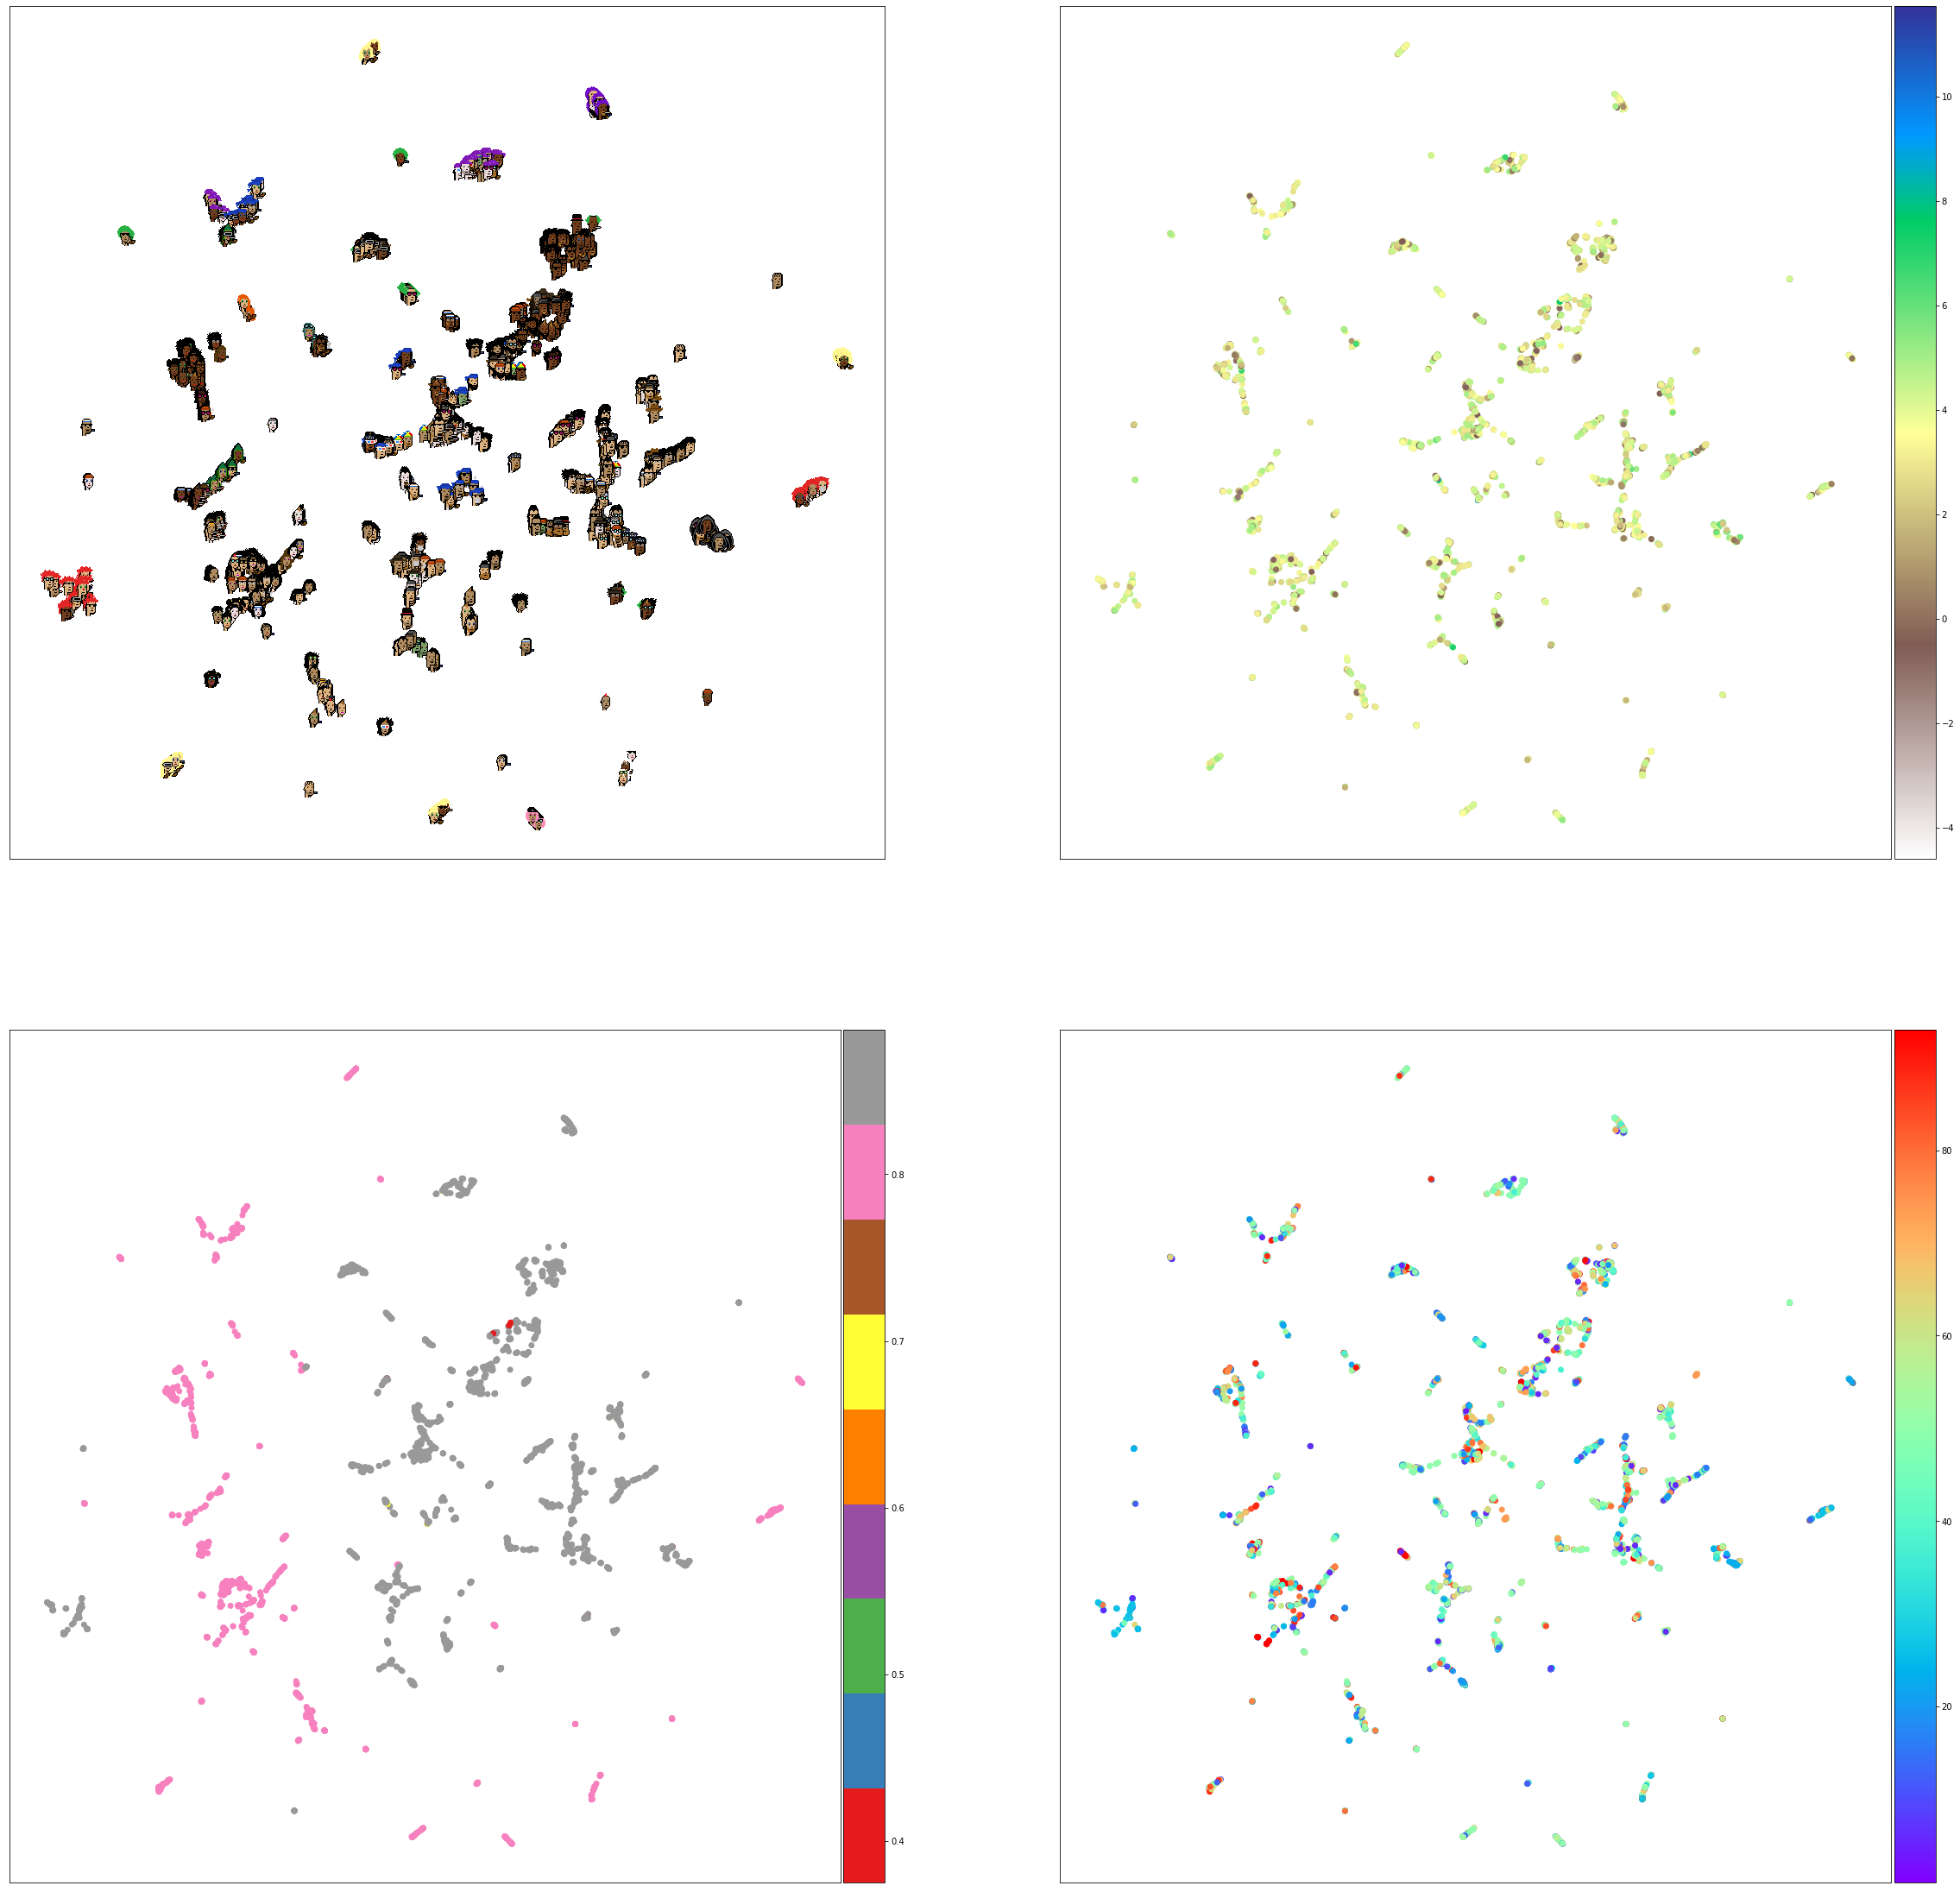

In [33]:
plot_embed(embedding,method='UMAP',p_color = punk_df_sale.total_price.values, traits=punk_df_sale.punk_type.values , clusters=punk_df_sale.labels_hier1.values)

In [328]:
# UMAP
data0 = list(data.values())
feat_array = np.array(data0)
feat_array1 = feat_array.reshape((4964,4096))
#idx = np.argwhere(np.all(an_array[..., :] == 0, axis=0))
#a2 = np.delete(an_array, idx, axis=1)

import statsmodels.tsa.arima_process as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#import umap
import umap.umap_ as umap
import math
%matplotlib inline
#import random
reducer = umap.UMAP(random_state=910, n_neighbors=5, min_dist =0.01)
last_layer = reducer.fit_transform(feat_array1)

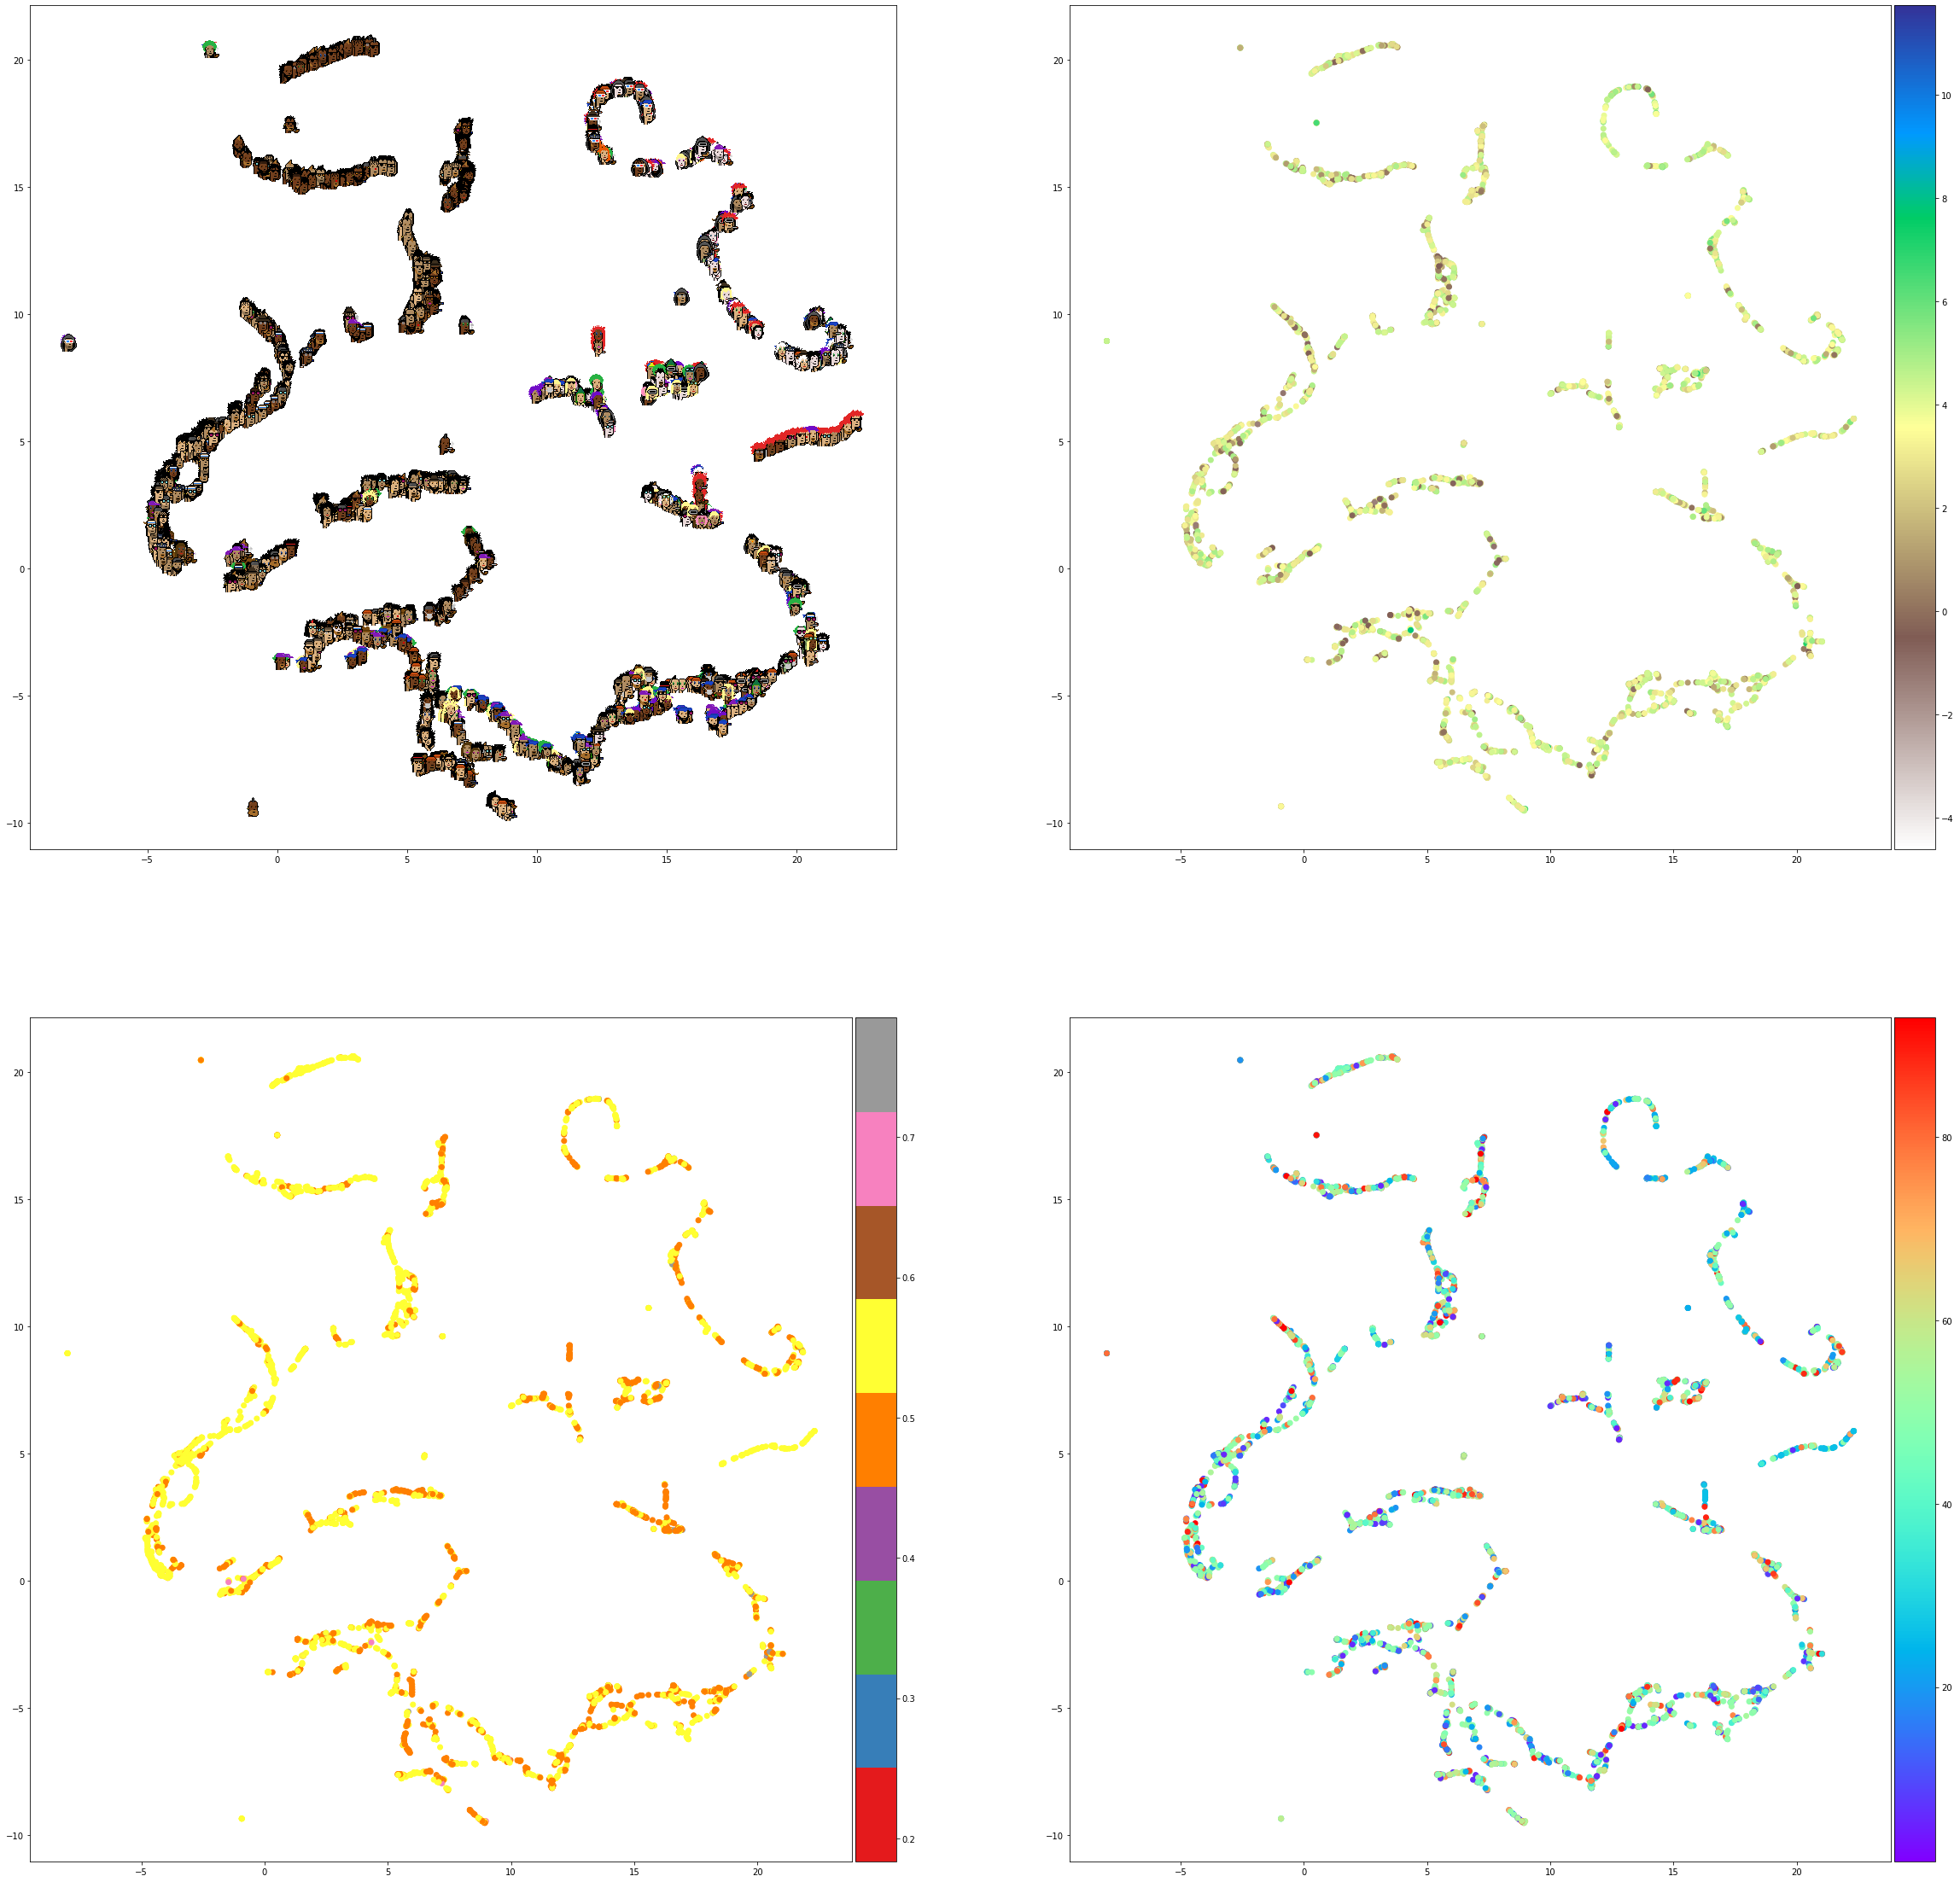

In [336]:
def plot_embed_CNN(embed,method,p_color, traits=punk_df_sale.punk_type.values , clusters=punk_df_sale.labels_hier1.values):
    fig = plt.figure(figsize=(40,40))
    ax1 = fig.add_subplot(221)
    im1 = ax1.scatter(embed[:, 0], embed[:, 1]) 
    im1.axes.get_xaxis().set_ticks([])
    im1.axes.get_yaxis().set_ticks([])
    for x0, y0, path in zip(embed[:, 0], embed[:, 1],img_path_sale):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax1.add_artist(ab)
    
    color = pd.DataFrame(np.log(p_color)).replace(-np.inf,0).iloc[:,0]
    orig_map=plt.cm.get_cmap('terrain')
    reversed_map = orig_map.reversed()
    ax2 = fig.add_subplot(222)
    im2 = ax2.scatter(embed[:, 0], embed[:, 1], c= np.array(color), cmap=reversed_map)
    im2.axes.get_xaxis().set_ticks([])
    im2.axes.get_yaxis().set_ticks([])
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    colors = [float(hash(s) % 256) / 256 for s in traits]
    ax3 = fig.add_subplot(223)    
    im3 = ax3.scatter(embed[:, 0], embed[:, 1], c=colors, cmap='Set1')
    im3.axes.get_xaxis().set_ticks([])
    im3.axes.get_yaxis().set_ticks([]) 
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    colors1 = clusters
    ax4 = fig.add_subplot(224)     
    im4 = ax4.scatter(embed[:, 0], embed[:, 1], c=np.array(colors1), cmap='rainbow')
    im4.axes.get_xaxis().set_ticks([])
    im4.axes.get_yaxis().set_ticks([])
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')
    plt.savefig(f'/Users/wendy/Documents/GitHub/UMAP/CNN_CryptoPunks_{method}.png',transparent=True)

plot_embed_CNN(last_layer,method='UMAP',p_color = punk_df_sale.total_price.values)

In [34]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding as LLE
reducer1 = LLE(n_neighbors=10, n_components=2, 
reg=0.001, eigen_solver='auto', tol=1e-06, max_iter=100, method='standard', 
hessian_tol=0.0001, modified_tol=1e-12, neighbors_algorithm='auto', random_state= 123)
embedding1 = reducer1.fit_transform(an_array2)

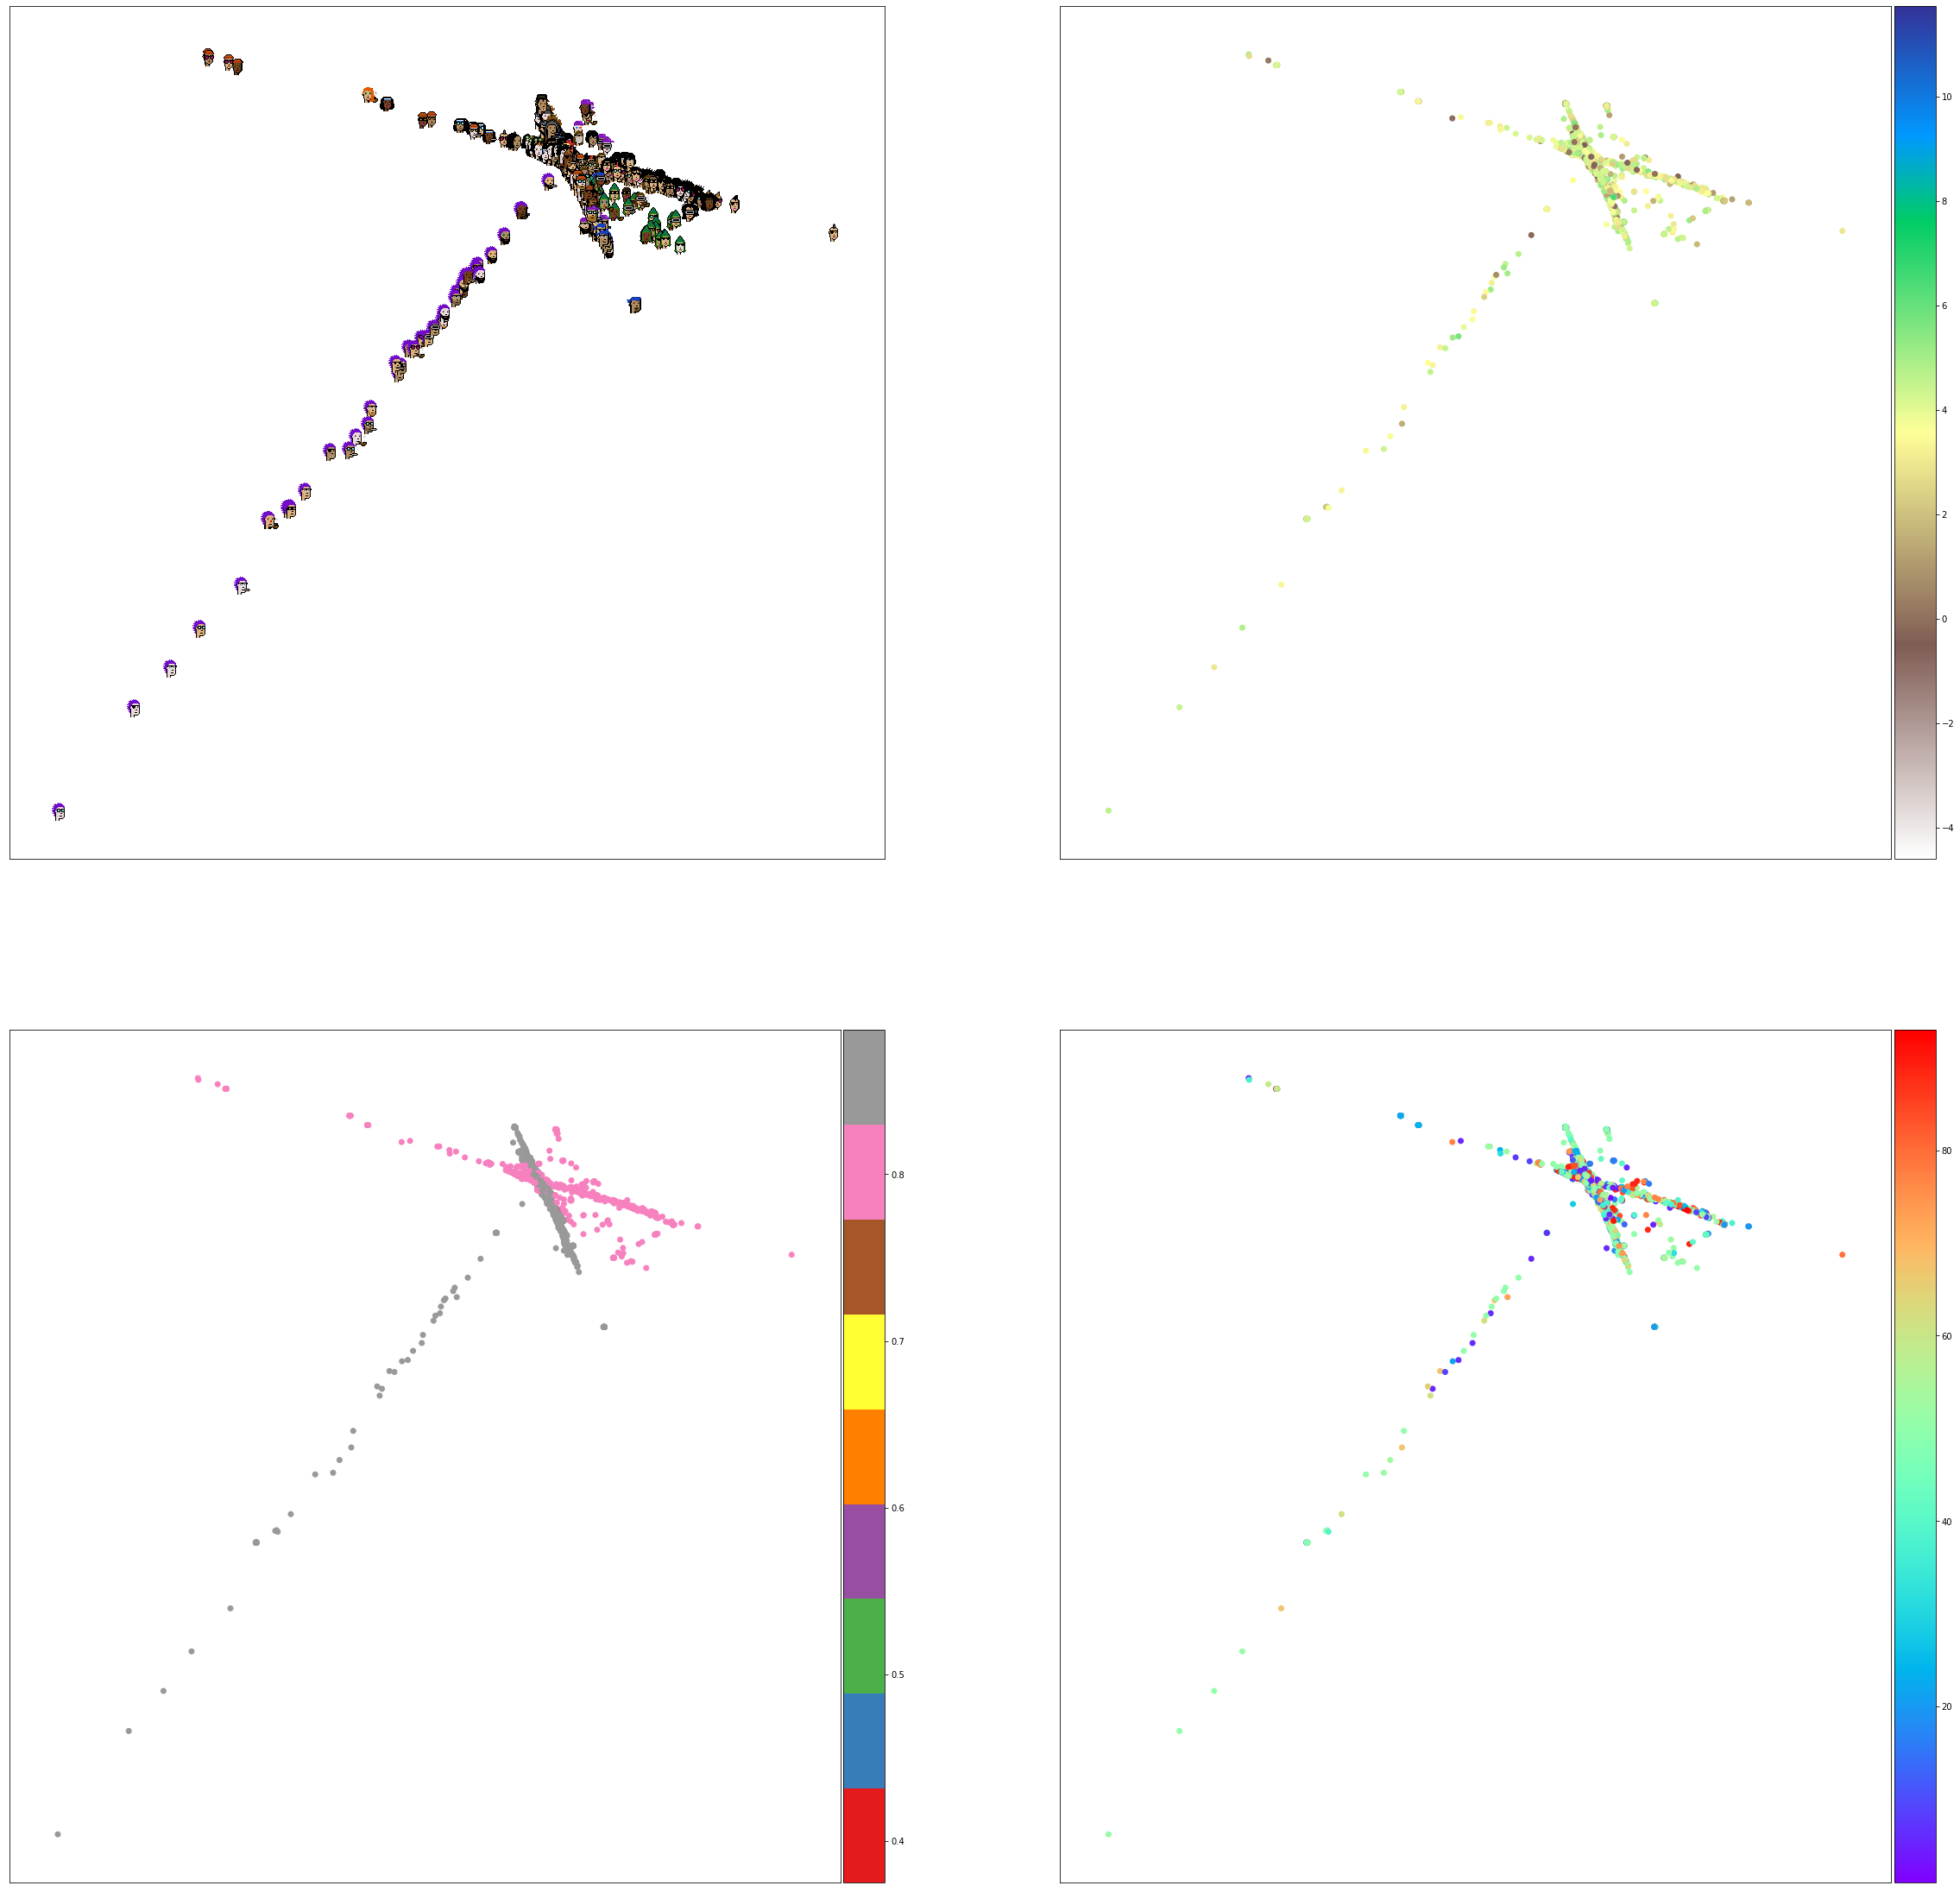

In [35]:
plot_embed(embedding1,method='LLE',p_color = punk_df_sale.total_price.values, traits=punk_df_sale.punk_type.values , clusters=punk_df_sale.labels_hier1.values)

In [36]:
#Isomap
from sklearn.manifold import Isomap
reducer2 = Isomap(n_neighbors=10, n_components=2)
embedding2 = reducer2.fit_transform(an_array2)

/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/wendy/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/wendy/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/wendy/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0]

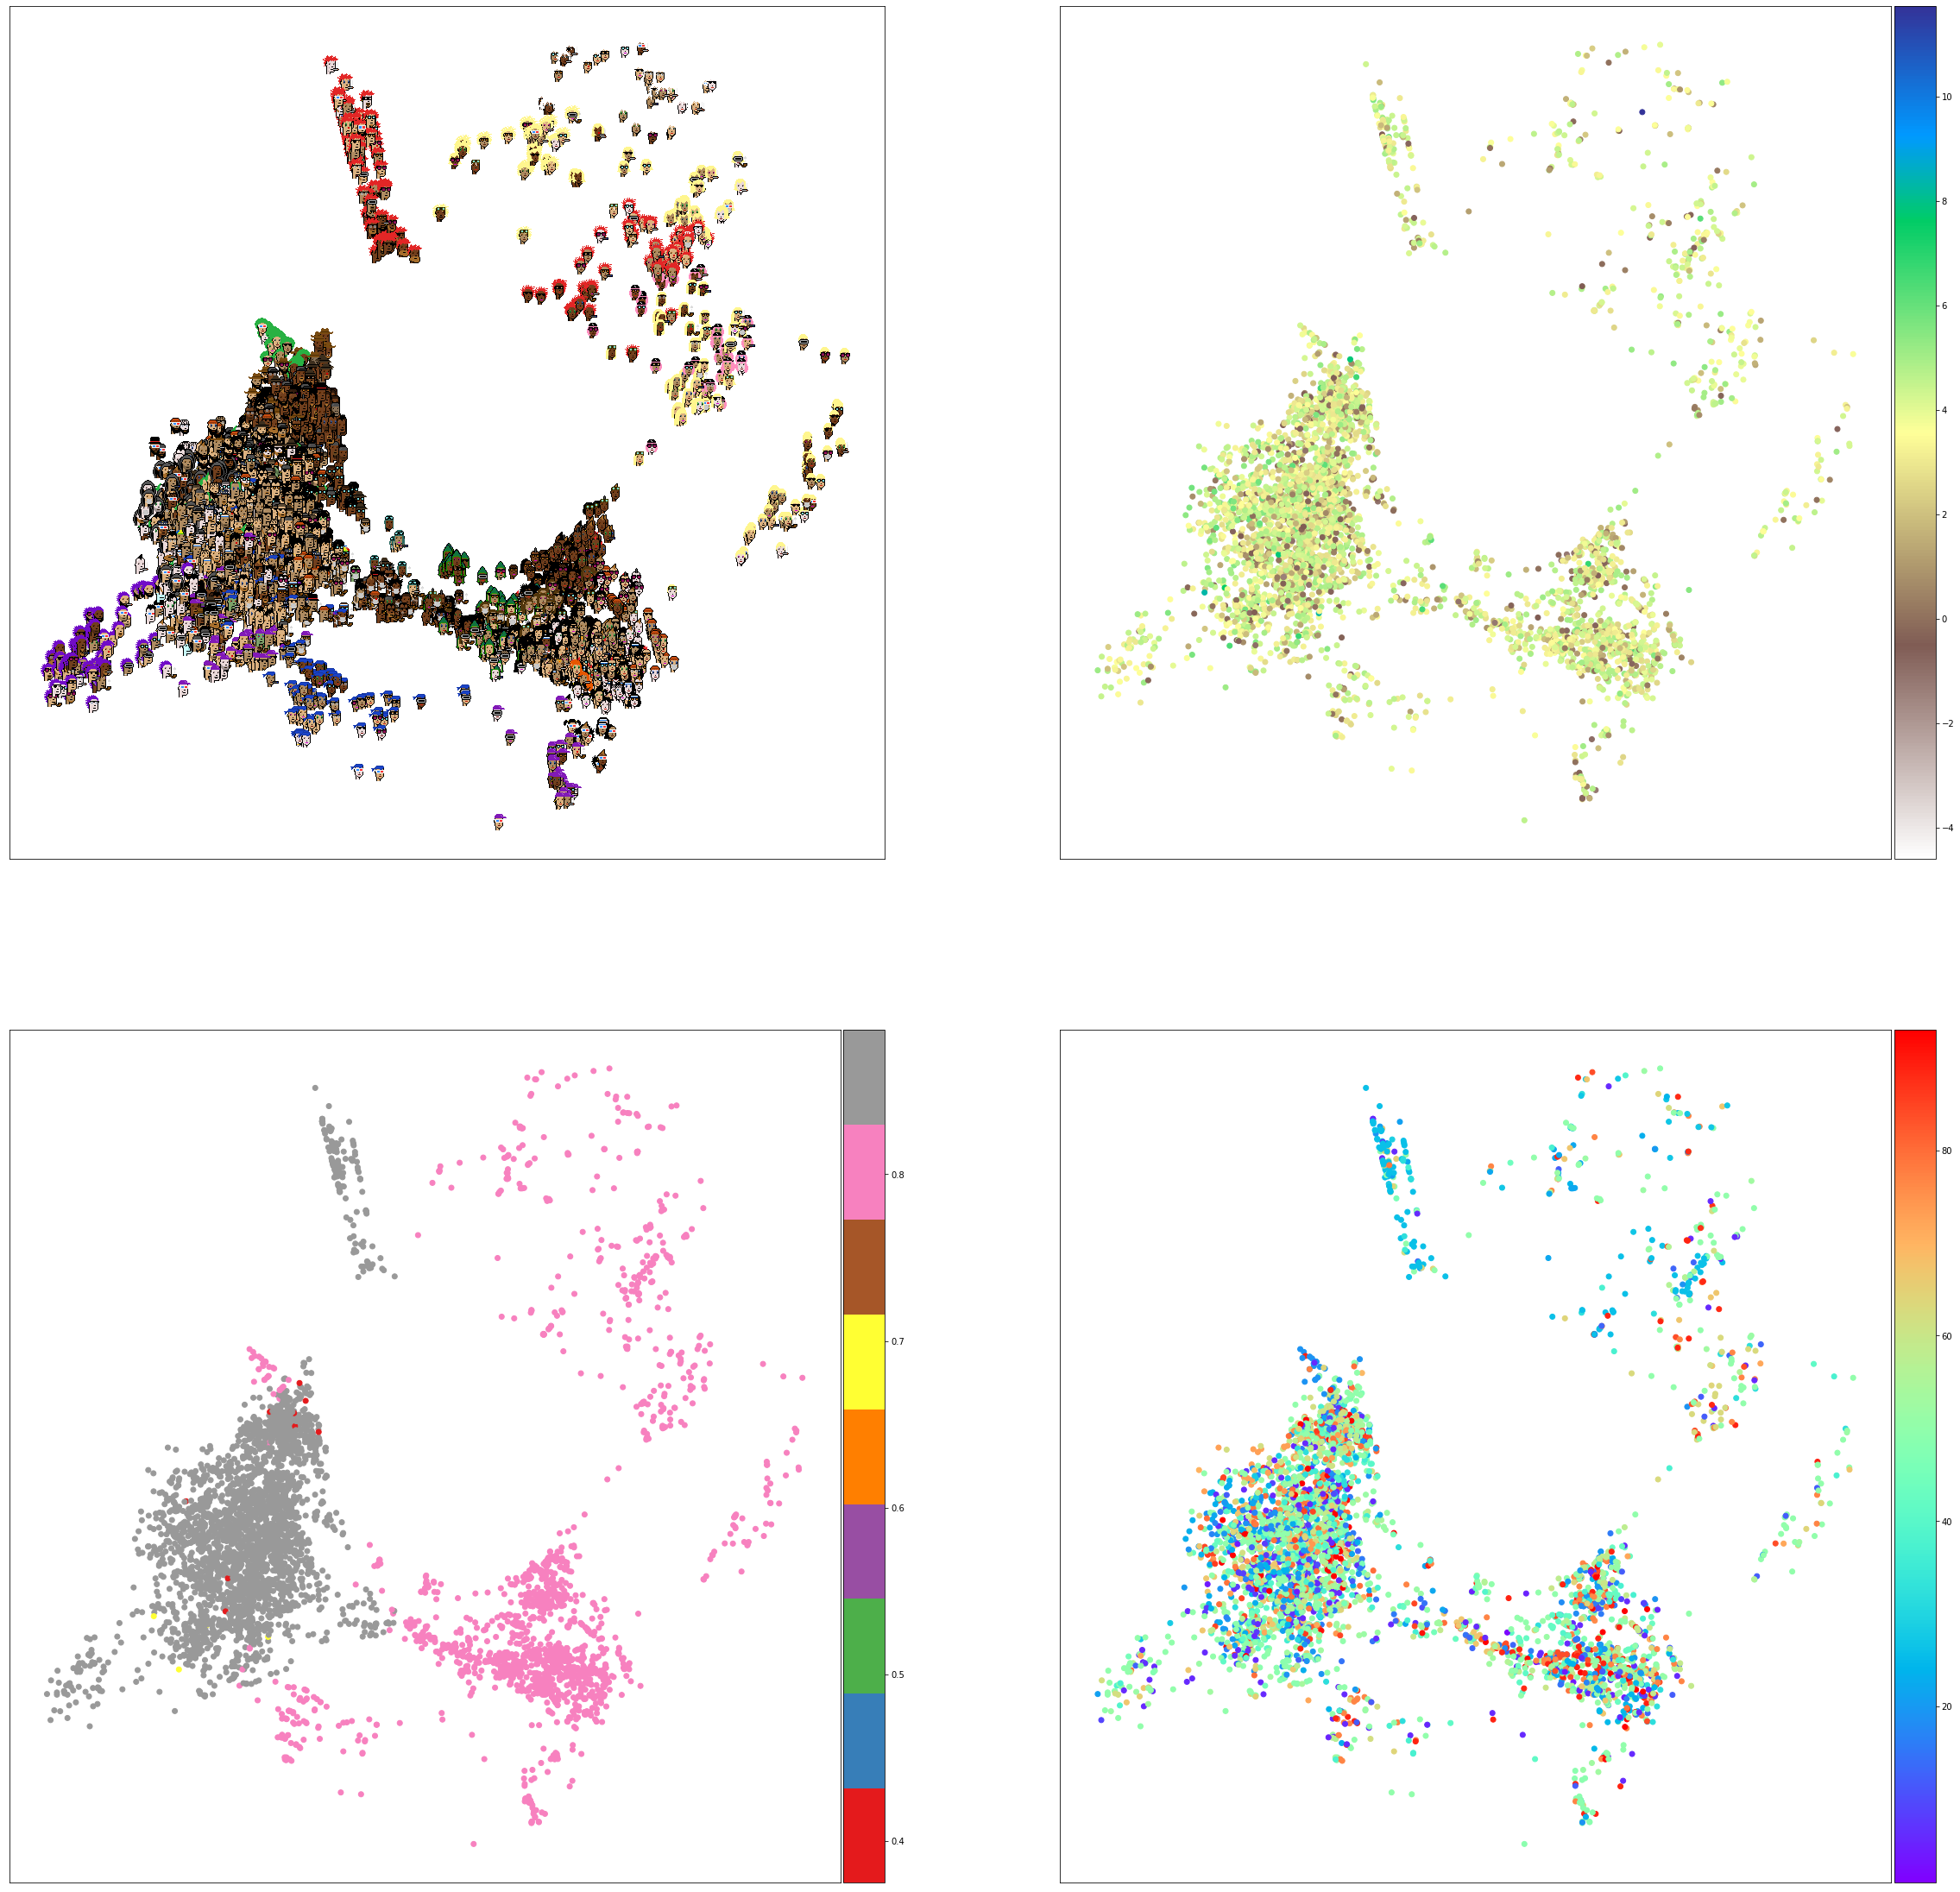

In [37]:
plot_embed(embedding2,method='Isomap',p_color = punk_df_sale.total_price.values, traits=punk_df_sale.punk_type.values , clusters=punk_df_sale.labels_hier1.values)

In [38]:
#TSNE
from sklearn.manifold import TSNE
reducer3 = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, random_state=123)
embedding3 = reducer3.fit_transform(an_array2)

/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


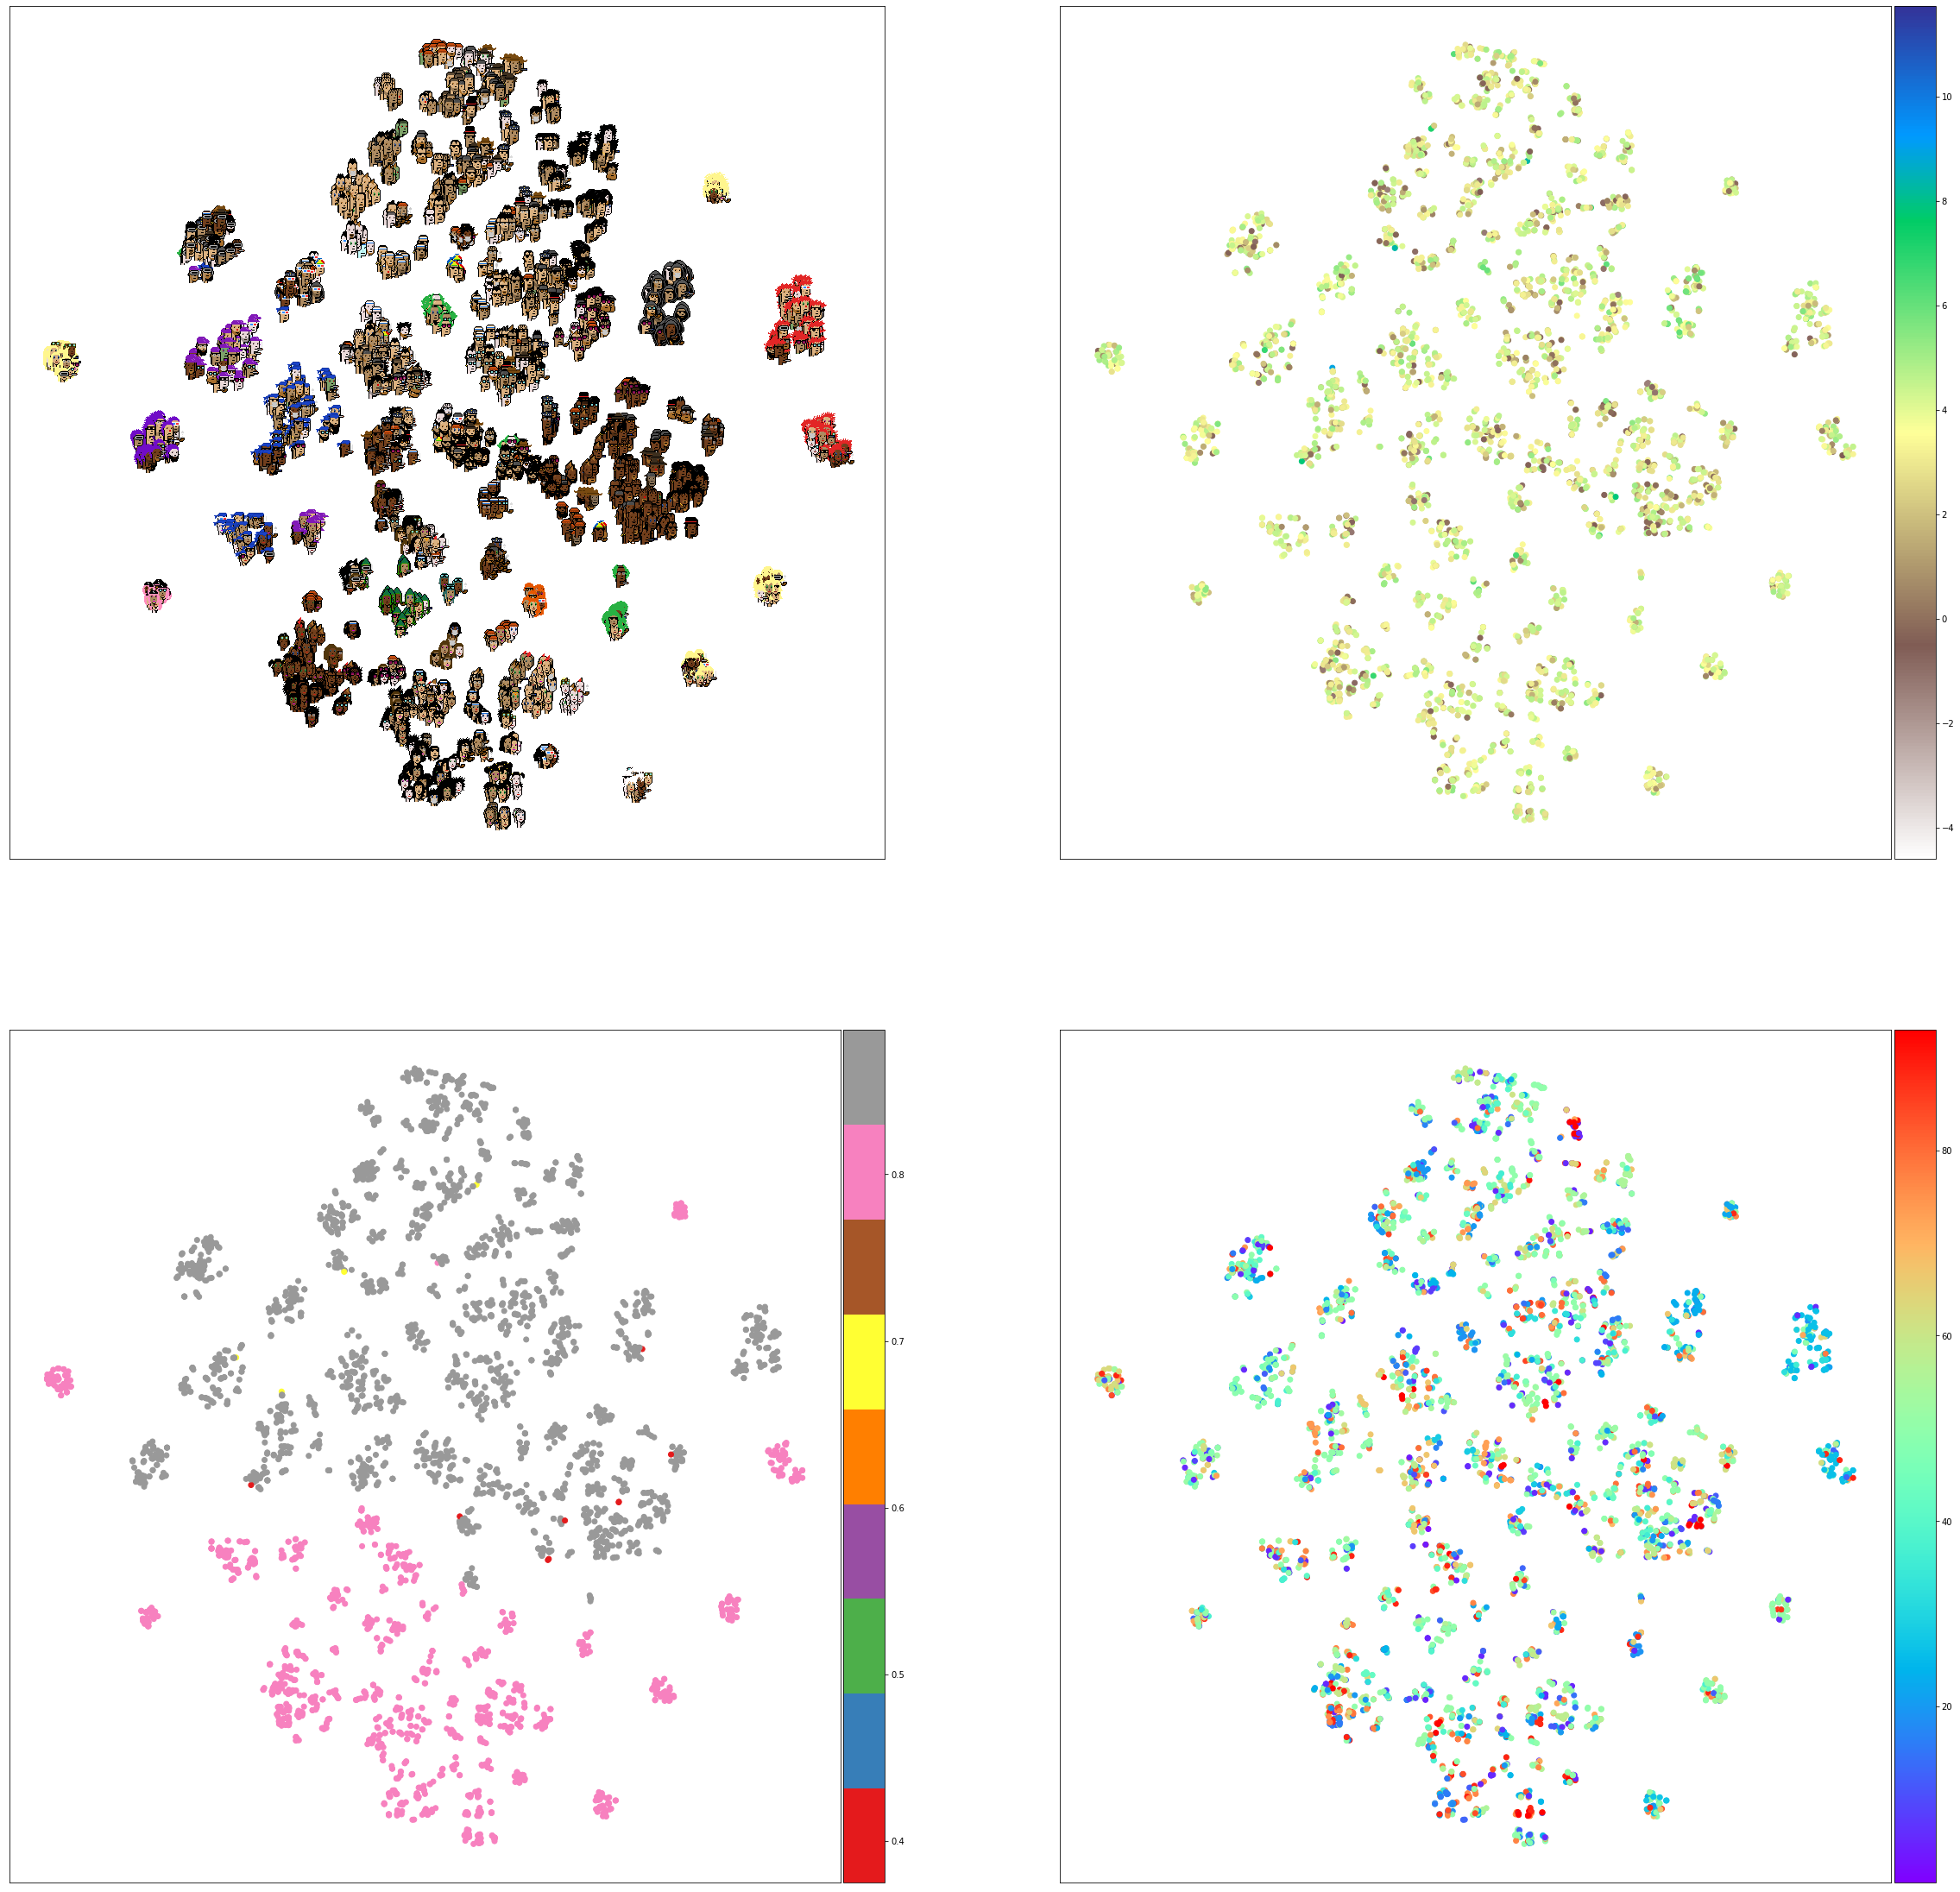

In [39]:
plot_embed(embedding3,method='TSNE',p_color = punk_df_sale.total_price, traits=punk_df_sale.punk_type , clusters=punk_df_sale.labels_hier1)

In [40]:
#MDS
from sklearn.manifold import MDS
reducer4 = MDS(n_components=2, metric=True, n_init=4, max_iter=300, 
verbose=0, eps=0.001, n_jobs=None, random_state= 123, dissimilarity='euclidean')
embedding4 = reducer4.fit_transform(an_array2)

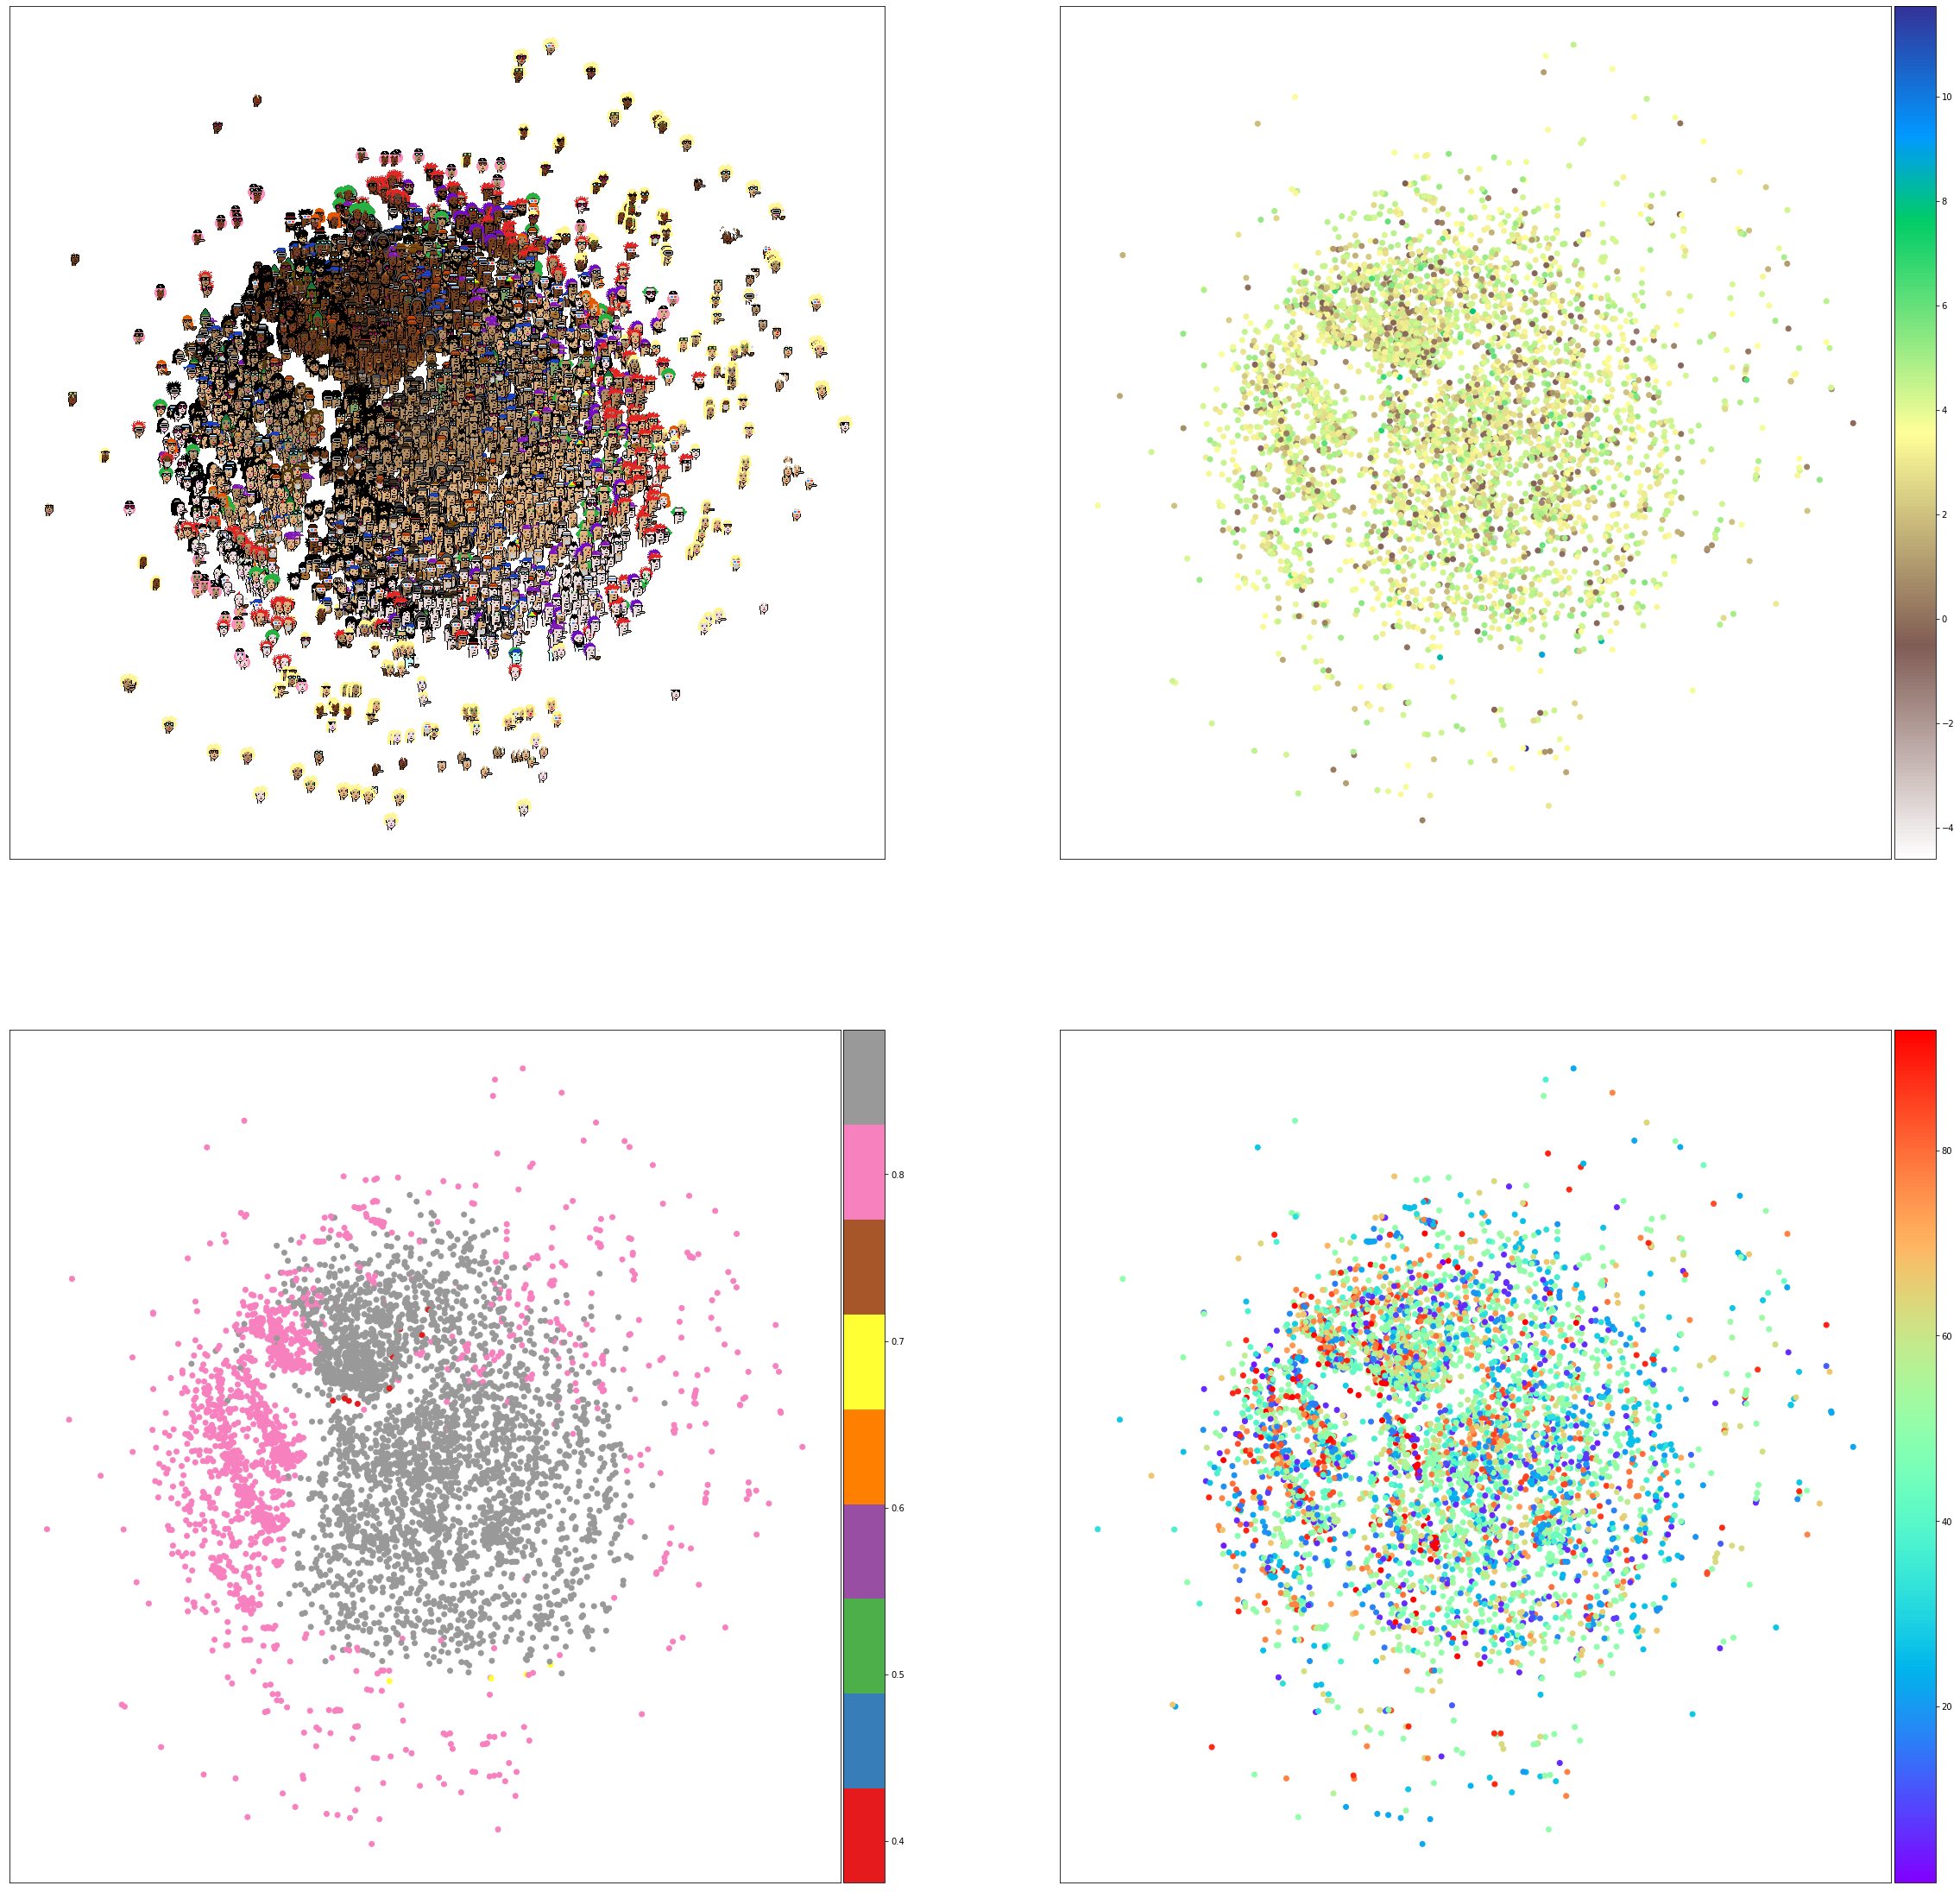

In [42]:
plot_embed(embedding4,method='MDS',p_color = punk_df_sale.total_price, traits=punk_df_sale.punk_type, clusters=punk_df_sale.labels_hier1)

In [242]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eigh
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

def find_diffusion_matrix(X=None, alpha=0.15):
    """Function to find the diffusion matrix P
        
        >Parameters:
        alpha - to be used for gaussian kernel function
        X - feature matrix as numpy array
        
        >Returns:
        P_prime, P, Di, K, D_left
    """
    alpha = alpha
        
    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2 / alpha)
    
    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))

    return P_prime, P, Di, K, D_left

def find_diffusion_map(P_prime, D_left, n_eign=3):
    """Function to find the diffusion coordinates in the diffusion space
        
        >Parameters:
        P_prime - Symmetrized version of Diffusion Matrix P
        D_left - D^{-1/2} matrix
        n_eigen - Number of eigen vectors to return. This is effectively 
                    the dimensions to keep in diffusion space.
        
        >Returns:
        Diffusion_map as np.array object
    """   
    n_eign = n_eign
    
    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    diffusion_coordinates = np.matmul(D_left, eigenVectors)
    
    return diffusion_coordinates[:,:n_eign]

def plot_2Dsub_figures(d_map, alpha_values, title='Diffused points'):
    subplot_titles=[f'α={round(a,4)}' for a in alpha_values]
    fig = make_subplots(rows=2, cols=5,subplot_titles=subplot_titles)
    for i in range(1,3):
        for j in range(1,6):
            dmap_idx = i+j-1
            fig.add_trace(
                go.Scatter(x=d_map[dmap_idx][:,0], y=d_map[dmap_idx][:,1], mode='markers', marker=dict(
                size=3,color=d_map[dmap_idx][:,1],opacity=0.8,colorscale='Viridis')),row=i, col=j)

    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=500, width=1000, showlegend=False)
    fig.show()

def apply_diffusions(data, alpha_start=0.001, alpha_end= 0.009, title='Diffused points'):
    d_maps = []
    alpha_values = np.linspace(alpha_start, alpha_end, 10)
    for alpha in alpha_values:
        P_prime, P, Di, K, D_left = find_diffusion_matrix(data, alpha=alpha)
        d_maps.append(find_diffusion_map(P_prime, D_left, n_eign=2))
    return d_maps, alpha_values

In [244]:
d_maps, alpha_values = apply_diffusions(an_array2, 0.1, 0.9)
plot_2Dsub_figures(d_maps,alpha_values)